In [2]:
# necessary imports
from utils import metrics
from utils.ensembles import EnsembleCPDModel

from utils.visualize import visualize_predictions

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from datetime import datetime
from typing import Any, Tuple

from tqdm.notebook import tqdm

import yaml

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload
%matplotlib inline

/home/a.stepikin/stash/stepikin/miniconda3/lib/python3.10/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
/home/a.stepikin/stash/stepikin/miniconda3/lib/python3.10/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/a.stepikin/stash/stepikin/miniconda3/lib/python3.10/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvisio

In [3]:
def compute_stds_list(model, test_dataloader, window):
    normal_stds_list = []
    cp_stds_list = []
    for batch, labels in tqdm(test_dataloader):
        preds_mean, preds_std = model.predict(batch)
        cp_idxs_batch = labels.cpu().argmax(axis=1)
        
        for cp_idx, std_series in zip(cp_idxs_batch, preds_std):
            if cp_idx == 0:
                normal_stds_list.append(std_series.mean().item())
            elif cp_idx < window + 1:
                cp_slice = std_series[:cp_idx + window]
                cp_stds_list.append(cp_slice.mean().item())
            else:
                cp_slice = std_series[cp_idx - window : cp_idx + window]
                normal_slice = std_series[:cp_idx - window]
                cp_stds_list.append(cp_slice.mean().item())
                normal_stds_list.append(normal_slice.mean().item())
    return normal_stds_list, cp_stds_list

In [4]:
def scores_aggregator_batch(
    series_batch: torch.Tensor,
    series_std_batch: torch.Tensor,
    global_sigma: float,
    lambda_null: float,
    lambda_inf: float,
    half_wnd: int,
    cusum_threshold: float
    ) -> Tuple[torch.Tensor, torch.Tensor]:
    """Compute CUSUM change point detection.

    :param series_mean:
    :param series_std:

    :returns: change_mask 
    """
    batch_size, seq_len = series_batch.shape

    normal_to_change_stat = torch.zeros(batch_size, seq_len).to(series_batch.device)
    change_mask = torch.zeros(batch_size, seq_len).to(series_batch.device)
    
    for i in range(1, seq_len):

        t = (series_batch[:, i] - 0.5) / global_sigma ** 2
        
        wnd_start = max(0, i - half_wnd)
        wnd_end = min(seq_len, i + half_wnd + 1)
        
        windom_var_sum = sum([series_std_batch[:, k] ** 2 for k in range(wnd_start, wnd_end)])

        normal_to_change_stat[:, i] = torch.maximum(
            (lambda_inf - lambda_null) * windom_var_sum,
            normal_to_change_stat[:, i - 1]
        ) + t

        is_change = normal_to_change_stat[:, i] > torch.ones(batch_size).to(series_batch.device) * cusum_threshold
        change_mask[is_change, i:] = True

    return change_mask, normal_to_change_stat

In [5]:
model_type = "seq2seq"
experiments_name = "human_activity"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config, 'r') as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type
args_config["loss_type"] = "bce"
args_config["num_workers"] = 2
args_config["learning"]["gpus"] = 1
args_config["learning"]["epochs"] = 100

In [6]:
ens_bce_har = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce_har.load_models_list("saved_models/human_activity/full_sample")


test_dataset = ens_bce_har.test_dataset
test_dataloader = DataLoader(test_dataset, batch_size = args_config["learning"]["batch_size"], shuffle=True)

In [7]:
batch, labels = next(iter(test_dataloader))
preds_mean, preds_std = ens_bce_har.predict(batch)

In [8]:
normal_stds_list, cp_stds_list = compute_stds_list(ens_bce_har, test_dataloader, window=2)

np.mean(normal_stds_list), np.mean(cp_stds_list)

  0%|          | 0/21 [00:00<?, ?it/s]

(0.01637909637267587, 0.02616774851593412)

In [11]:
norm_sigma = np.mean(normal_stds_list)
cp_sigma = np.mean(cp_stds_list)

global_sigma = norm_sigma
lambda_null = 1. / cp_sigma ** 2
lambda_inf = 1. / norm_sigma ** 2
half_wnd = 1
cusum_threshold = 5.0

lambda_null, lambda_inf

(1460.3847367611927, 3727.52121149452)

In [13]:
norm_sigma, cp_sigma

(0.01637909637267587, 0.02616774851593412)

In [10]:
global_sigma

0.01637909637267587

In [68]:
seq_batch, labels_batch = next(iter(test_dataloader))

preds_mean, preds_std = ens_bce_har.predict(seq_batch)

cusum_preds, cusum_stat = scores_aggregator_batch(
    preds_mean,
    preds_std,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    cusum_threshold=cusum_threshold
)

cusum_stat = cusum_stat.detach().cpu()
cusum_preds = cusum_preds.detach().cpu()

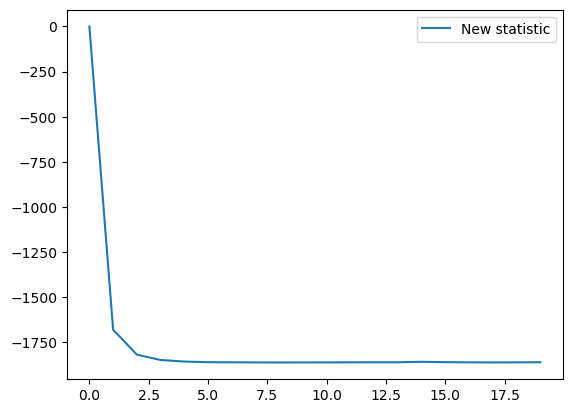

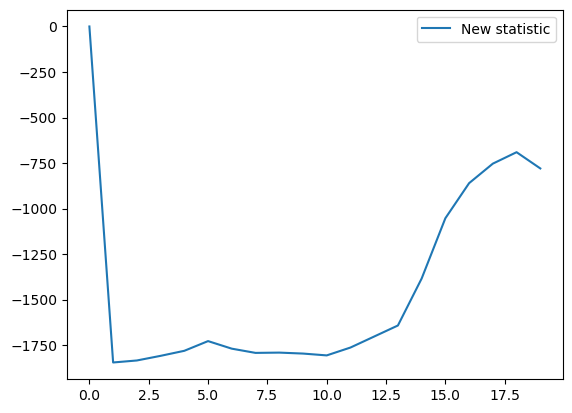

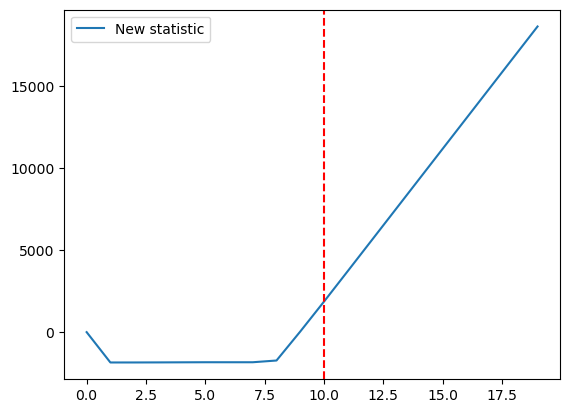

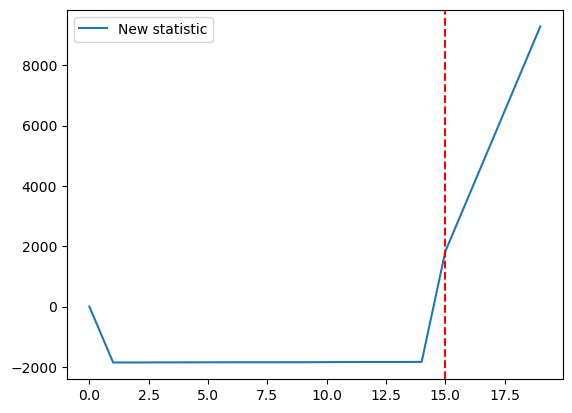

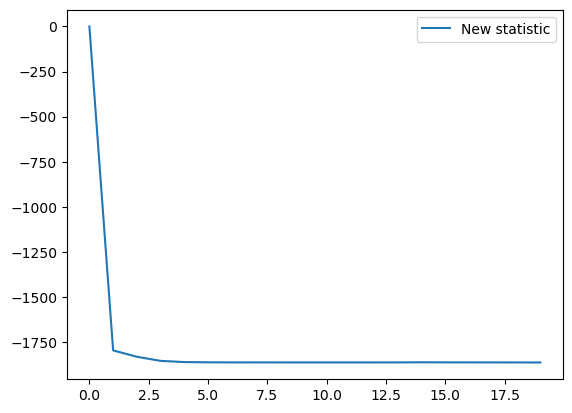

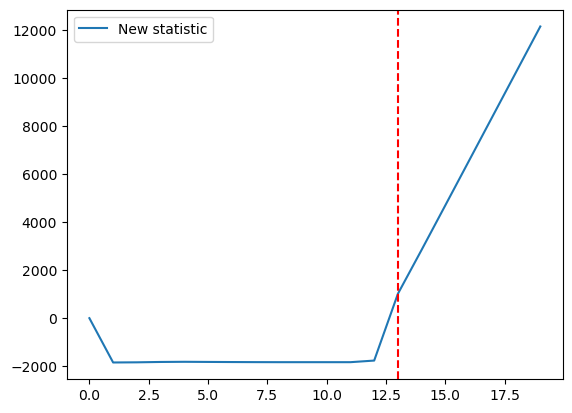

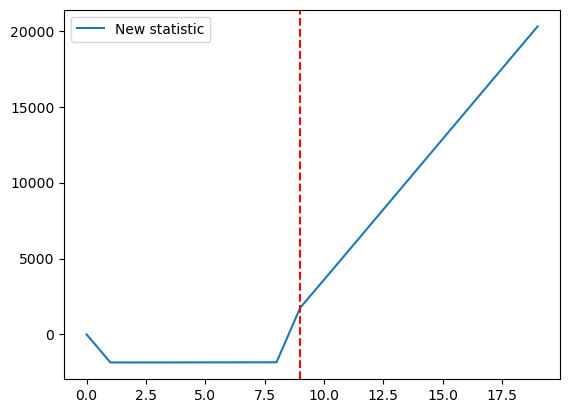

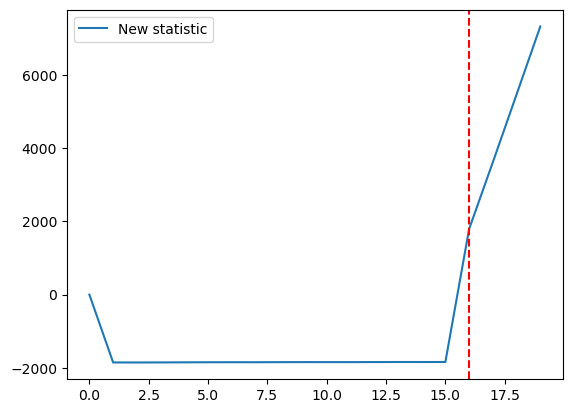

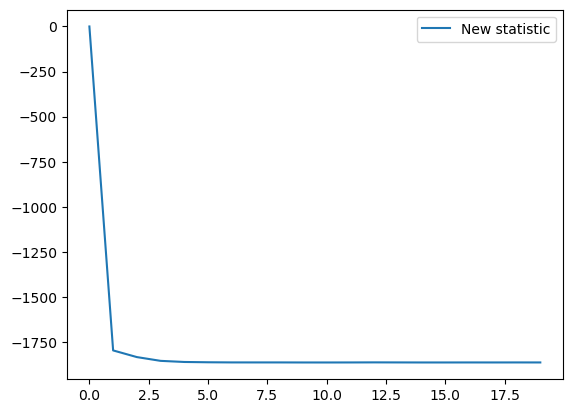

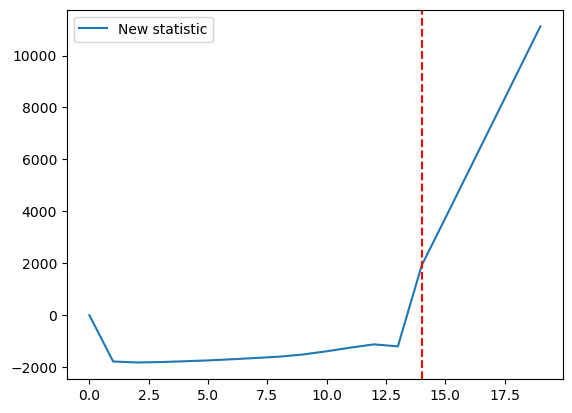

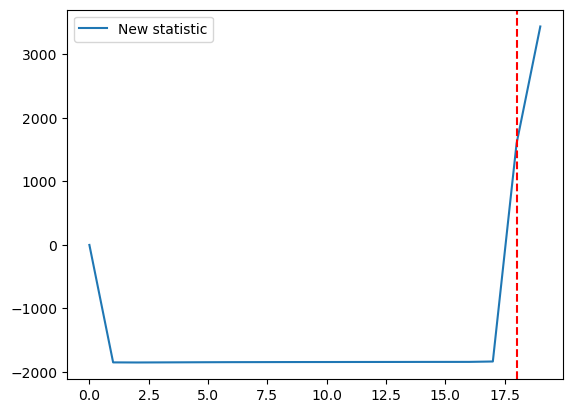

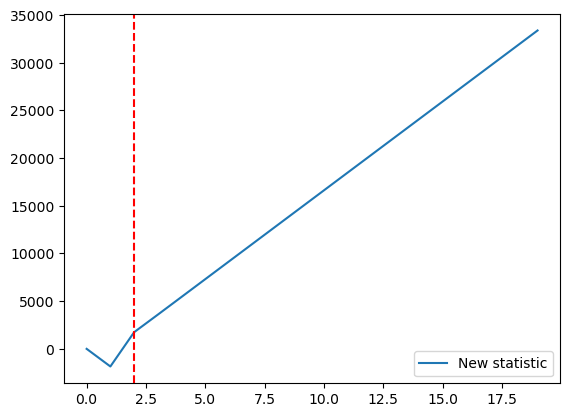

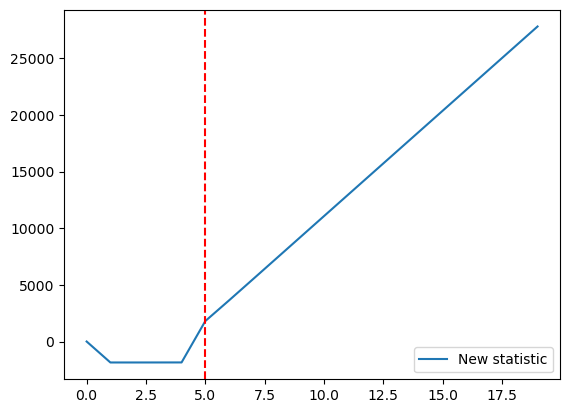

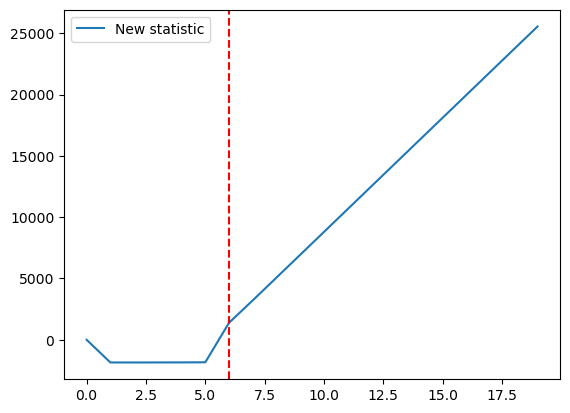

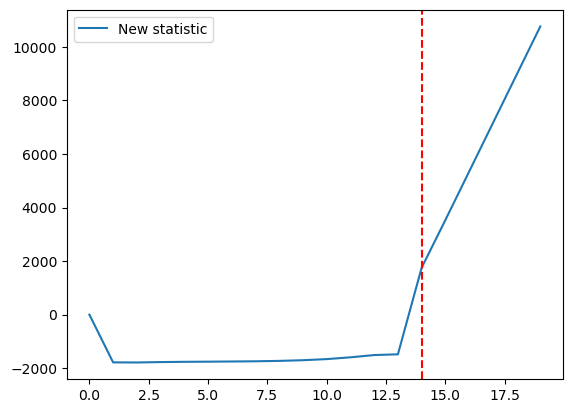

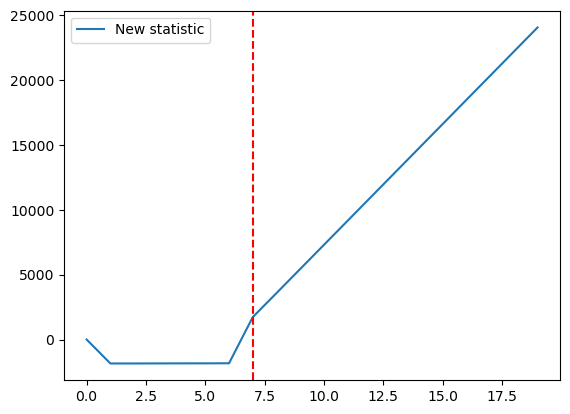

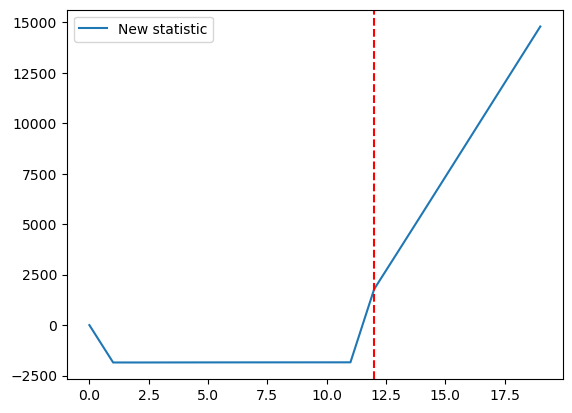

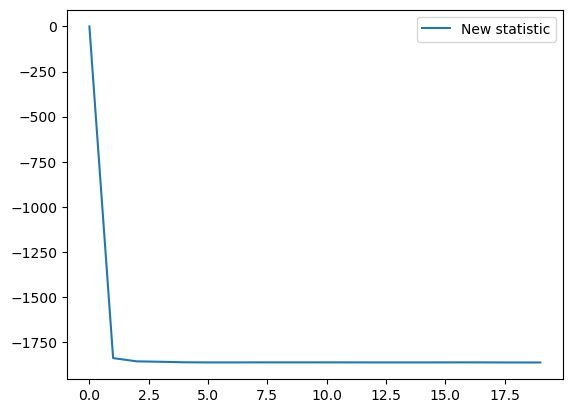

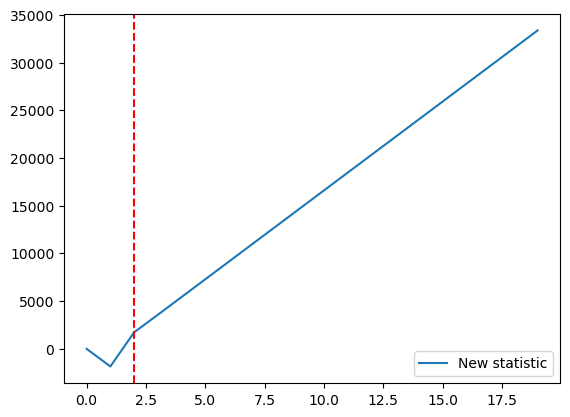

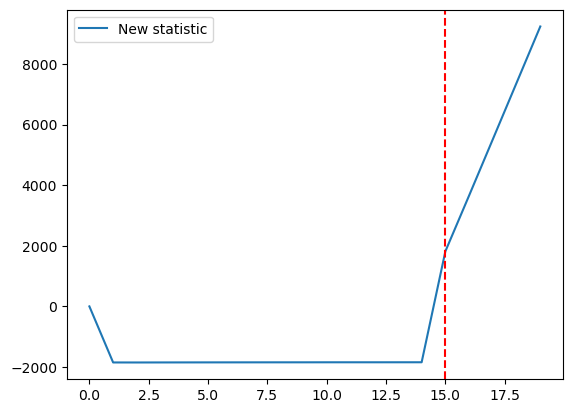

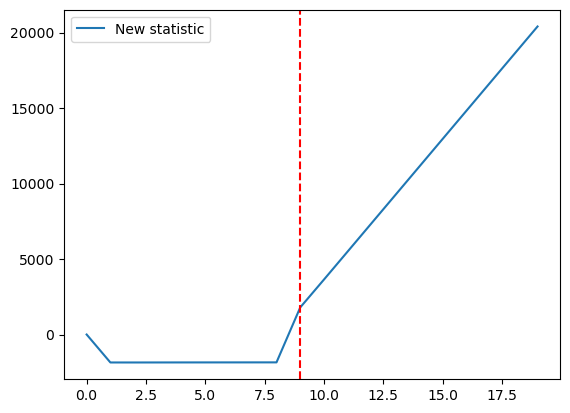

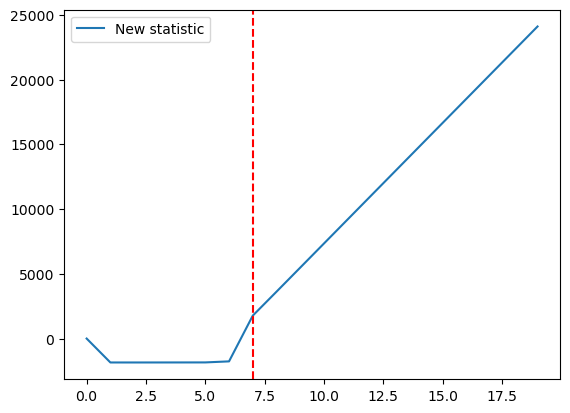

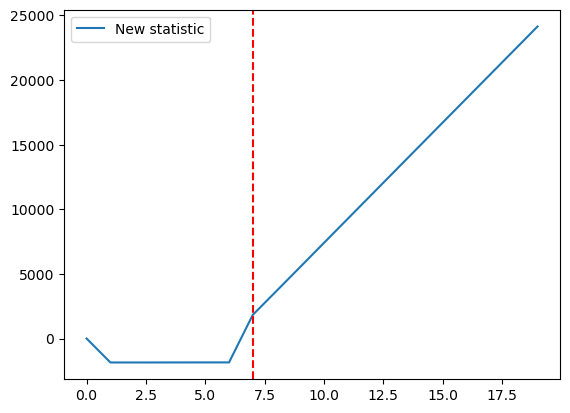

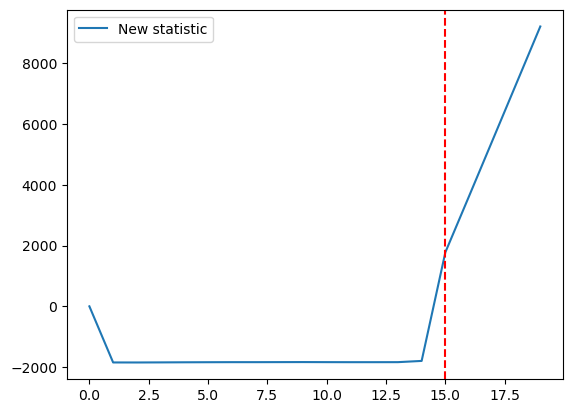

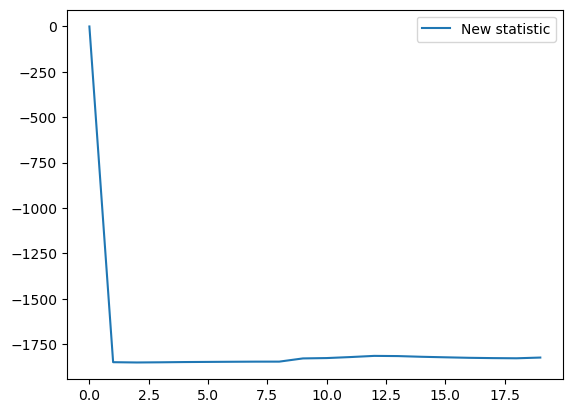

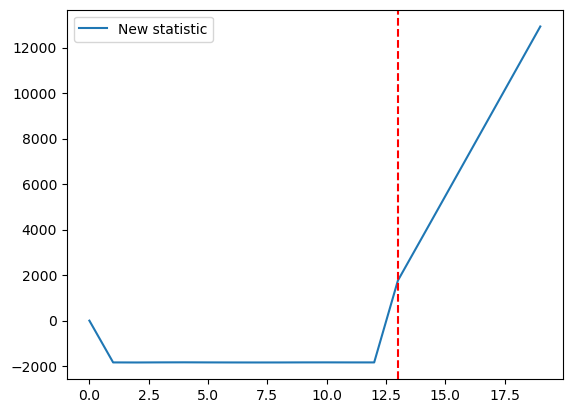

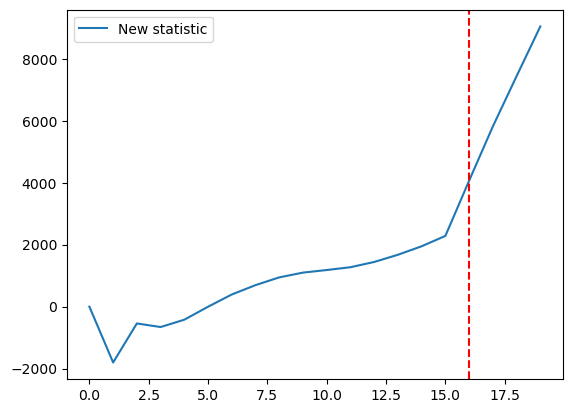

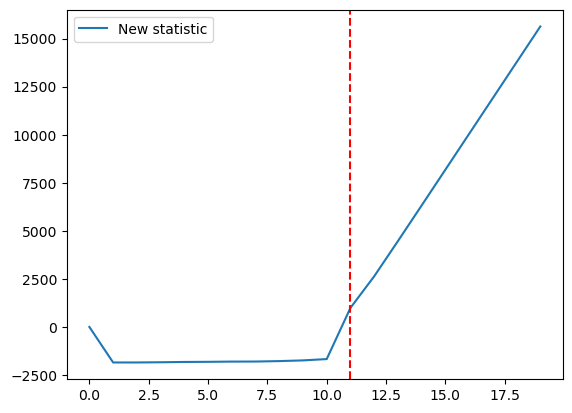

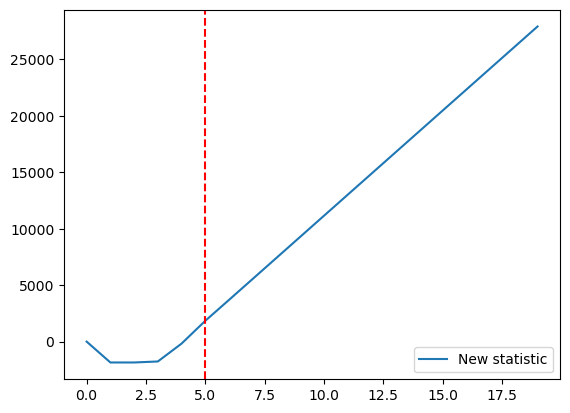

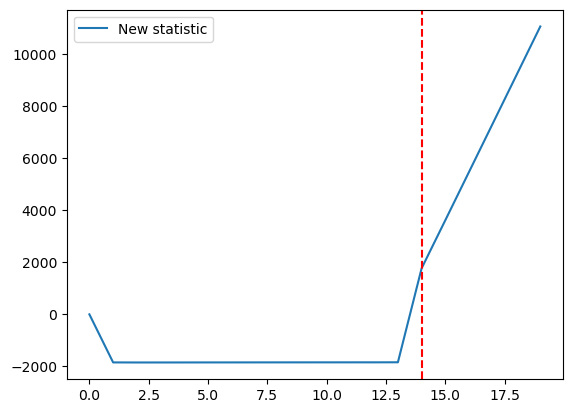

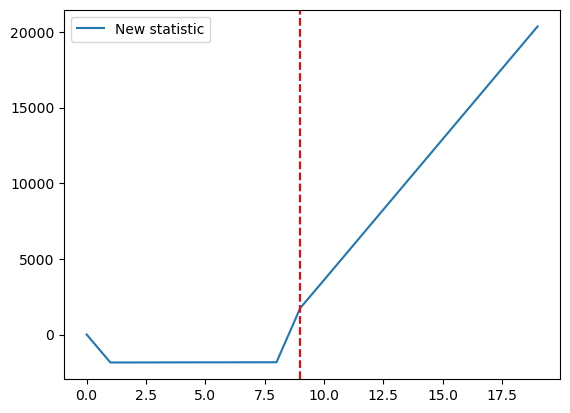

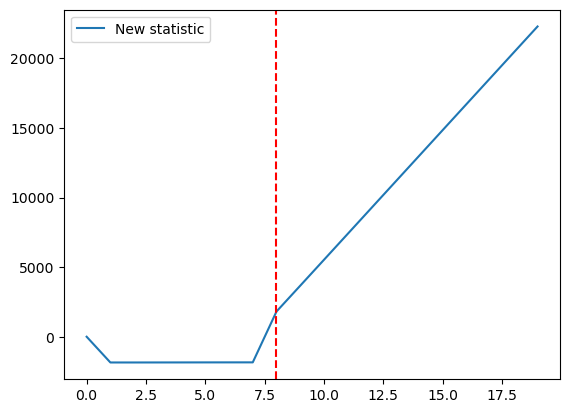

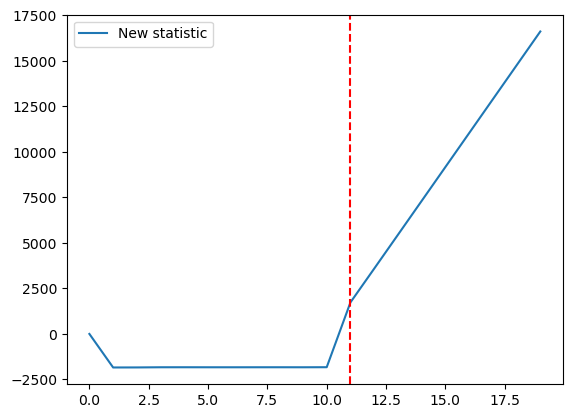

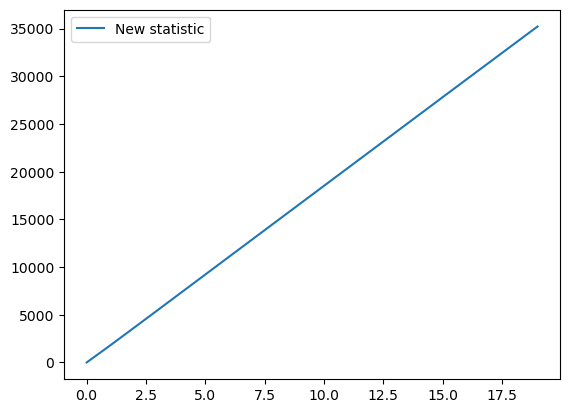

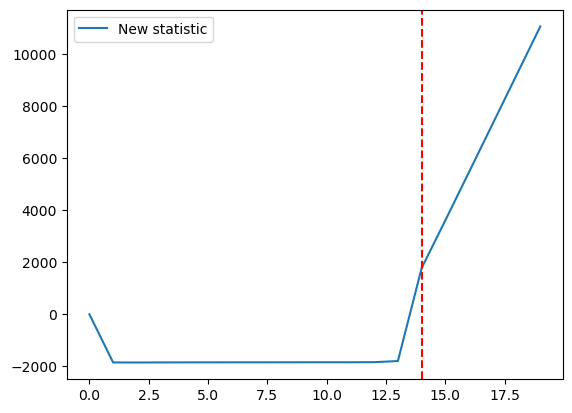

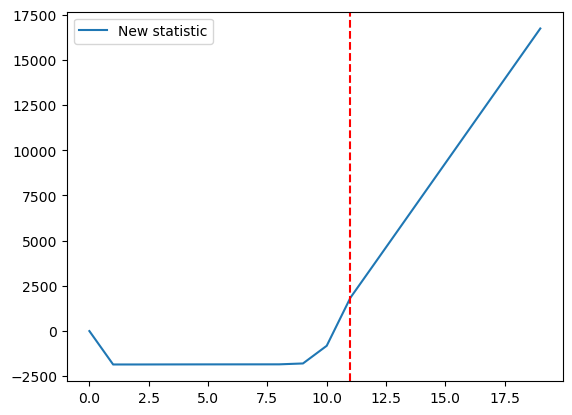

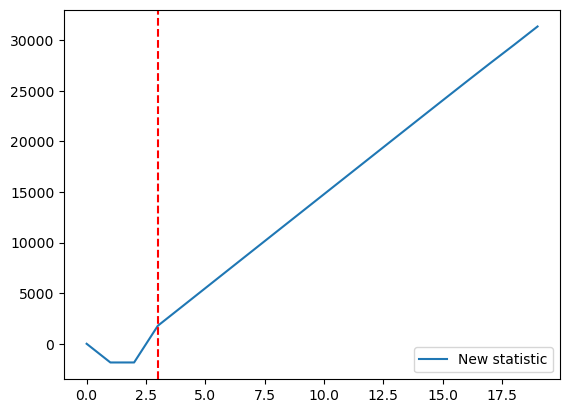

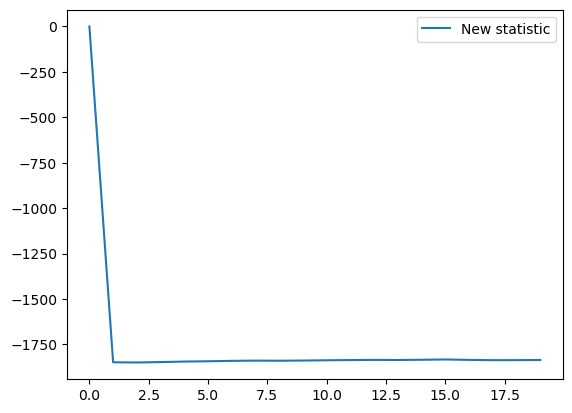

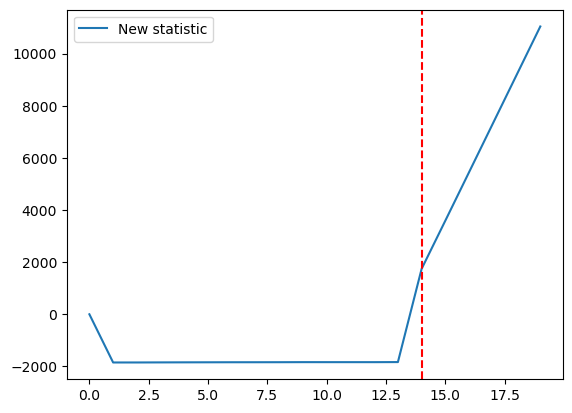

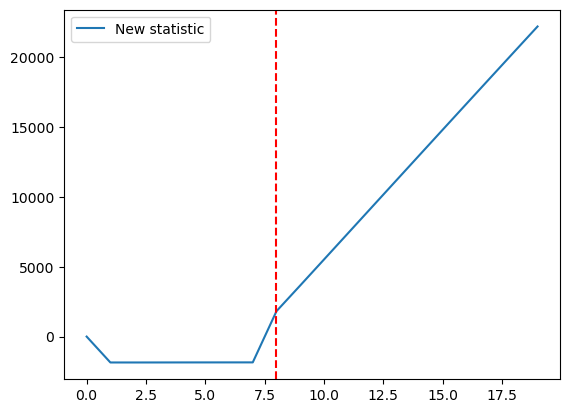

In [69]:
for IDX in range(40):

    change_idx = labels_batch[IDX].detach().cpu().numpy().argmax()

    plt.figure()
    plt.plot(cusum_stat[IDX], label="New statistic")
    if change_idx > 0:
        plt.axvline(x = change_idx, c="red", linestyle="--")
    plt.legend()
    plt.show()

In [1]:
class AggregationEnsembleCPDModel(EnsembleCPDModel):
    """Wrapper for cusum aproach ensemble models."""

    def __init__(
        self,
        args: dict,
        n_models: int,
        boot_sample_size: int = None,
        # scale_by_std: bool = True,
        global_sigma: float = 0.02,
        lambda_null: float = 1500,
        lambda_inf: float = 4000,
        half_wnd: int = 1,
        cusum_threshold: float = 0.1,
        seed: int = 0
        
    ) -> None:
        """Initialize EnsembleCPDModel.

        :param args: dictionary containing core model params, learning params, loss params, etc.
        :param n_models: number of models to train
        :param boot_sample_size: size of the bootstrapped train dataset 
                                 (if None, all the models are trained on the original train dataset)
        :param scale_by_std: if True, scale the statistic by predicted std, i.e.
                                in cusum, t = series_mean[i] - series_mean[i-1]) / series_std[i],
                             else:
                                t = series_mean[i] - series_mean[i-1]
        :param susum_threshold: threshold for CUSUM algorithm
        :param seed: random seed to be fixed
        """
        super().__init__(args, n_models, boot_sample_size, seed)
        self.cusum_threshold = cusum_threshold
        # self.scale_by_std = scale_by_std
    
    def cusum_detector_batch(
        self, series_batch: torch.Tensor, series_std_batch: torch.Tensor
        ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Compute CUSUM change point detection.
        
        :param series_mean:
        :param series_std:
        
        :returns: change_mask 
        """
        batch_size, seq_len = series_batch.shape
        
        normal_to_change_stat = torch.zeros(batch_size, seq_len).to(series_batch.device)
        change_mask = torch.zeros(batch_size, seq_len).to(series_batch.device)
        
        for i in range(1, seq_len):
            
            t = (series_batch[:, i] - 0.5) / global_sigma ** 2
        
            wnd_start = max(0, i - half_wnd)
            wnd_end = min(seq_len, i + half_wnd + 1) # include both boundaries

            windom_var_sum = sum([series_std_batch[:, k] ** 2 for k in range(wnd_start, wnd_end)])

            normal_to_change_stat[:, i] = torch.maximum(
                (lambda_inf - lambda_null) * windom_var_sum,
                normal_to_change_stat[:, i - 1]
            ) + t
            
            is_change = normal_to_change_stat[:, i] > torch.ones(batch_size).to(series_batch.device) * self.cusum_threshold
            change_mask[is_change, i:] = True
            
        return change_mask, normal_to_change_stat
    
    def sample_cusum_trajectories(self, inputs):
                
        if not self.fitted:
            print("Attention! The model is not fitted yet.")
            
        ensemble_preds = []
        
        for model in self.models_list:
            ensemble_preds.append(model(inputs).squeeze())
        
        # shape is (n_models, batch_size, seq_len)
        ensemble_preds = torch.stack(ensemble_preds)
        #print("ensemble_preds:", ensemble_preds.shape)
        
        cusum_trajectories = []
        change_masks = []
        
        for preds_traj in ensemble_preds:
            # use one_like tensor of std's, do not take them into account
            change_mask, normal_to_change_stat = self.cusum_detector_batch(preds_traj, torch.ones_like(preds_traj))
            cusum_trajectories.append(normal_to_change_stat)
            change_masks.append(change_mask)
        
        cusum_trajectories = torch.stack(cusum_trajectories)
        change_masks = torch.stack(change_masks)
        
        return change_masks, cusum_trajectories
    
    def predict(self, inputs: torch.Tensor, scale: int = None) -> torch.Tensor:
        """Make a prediction.
        
        :param inputs: input batch of sequences
        
        :returns: torch.Tensor containing predictions of all the models
        """
        
        if not self.fitted:
            print("Attention! The model is not fitted yet.")
            
        ensemble_preds = []
        for model in self.models_list:
            if self.args["model_type"] == "seq2seq":
                ensemble_preds.append(model(inputs))
            elif self.args["model_type"] == "kl_cpd":
                outs = klcpd.get_klcpd_output_scaled(model, inputs, model.window_1, model.window_2, scale=scale)
                ensemble_preds.append(outs)
            elif self.args["model_type"] == "tscp":
                outs = tscp.get_tscp_output_scaled(model, inputs, model.window_1, model.window_2, scale=scale)
                ensemble_preds.append(outs)
            else:
                raise ValueError(f'Wrong or not implemented model type {self.args["model_type"]}.')

        preds_mean = torch.mean(ensemble_preds, axis=0).squeeze()
        preds_std = torch.std(ensemble_preds, axis=0).squeeze()
        
        # store current predictions
        self.preds = ensemble_preds
        
        change_masks, normal_to_change_stats = self.cusum_detector_batch(preds_mean, preds_std)

        self.preds_mean = preds_mean
        self.preds_std = preds_std
        self.change_masks = change_masks
        self.normal_to_change_stats = normal_to_change_stats
        
        return change_masks
    
    def predict_cusum_trajectories(self, inputs: torch.Tensor, q: float = 0.5) -> torch.Tensor:
        """Make a prediction.
        
        :param inputs: input batch of sequences
        
        :returns: torch.Tensor containing predictions of all the models
        """
        change_masks, _ = self.sample_cusum_trajectories(inputs)
        
        cp_idxs_batch = torch.argmax(change_masks, dim=2).float()
        
        cp_idxs_batch_aggr = torch.quantile(cp_idxs_batch, q, axis=0).round().int()
        
        _, bs, seq_len = change_masks.shape
        
        cusum_quantile_labels = torch.zeros(bs, seq_len).to(inputs.device)
        
        for b in range(bs):
            if cp_idxs_batch_aggr[b] > 0:
                cusum_quantile_labels[b, cp_idxs_batch_aggr[b]:] = 1
        
        return cusum_quantile_labels

NameError: name 'EnsembleCPDModel' is not defined

In [71]:
half_wnd = 1
normal_stds_list, cp_stds_list = compute_stds_list(ens_bce_har, test_dataloader, window=half_wnd)

norm_sigma = np.mean(normal_stds_list)
cp_sigma = np.mean(cp_stds_list)

global_sigma = norm_sigma
lambda_null = 1 / cp_sigma ** 2
lambda_inf = 1 / norm_sigma ** 2

np.mean(normal_stds_list), np.mean(cp_stds_list)

  0%|          | 0/21 [00:00<?, ?it/s]

(0.01649960386941775, 0.032072982538612294)

In [73]:
cusum_threshold_list = np.linspace(0, 10, 51) * 1000
cusum_threshold_list

array([    0.,   200.,   400.,   600.,   800.,  1000.,  1200.,  1400.,
        1600.,  1800.,  2000.,  2200.,  2400.,  2600.,  2800.,  3000.,
        3200.,  3400.,  3600.,  3800.,  4000.,  4200.,  4400.,  4600.,
        4800.,  5000.,  5200.,  5400.,  5600.,  5800.,  6000.,  6200.,
        6400.,  6600.,  6800.,  7000.,  7200.,  7400.,  7600.,  7800.,
        8000.,  8200.,  8400.,  8600.,  8800.,  9000.,  9200.,  9400.,
        9600.,  9800., 10000.])

## + inside maximum

In [74]:
threshold_list = [0.5]

for cusum_threshold in cusum_threshold_list:
    print("cusum_threshold:", cusum_threshold)
    ens_har_bce_new_aggr = AggregationEnsembleCPDModel(
        args_config,
        n_models=10,
        global_sigma=global_sigma,
        lambda_null=lambda_null,
        lambda_inf=lambda_inf,
        half_wnd=half_wnd,
        cusum_threshold=cusum_threshold,
    )

    ens_har_bce_new_aggr.load_models_list("saved_models/human_activity/full_sample")
    # no need in threshold list for CUSUM-aggregated CP scores

    # compute metrics
    metrics_local, delay_list, fp_delay_list = \
        metrics.evaluation_pipeline(ens_har_bce_new_aggr,
                                    test_dataloader,
                                    threshold_list,
                                    device="cuda", # choose 'cpu' or 'cuda' if available
                                    model_type="cusum_aggr",
                                    verbose=True,
                                    )

cusum_threshold: 0.0


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/it]

TN: 0, FP: 1219, FN: 0, TP: 118, DELAY:0.017202692106366158, FP_DELAY:0.9349289536476135, COVER: 0.6721584064874228
AUC: None
Time to FA 0.9349, delay detection 0.0172 for best-F1 threshold: 0.5
TN 0, FP 1219, FN 0, TP 118 for best-F1 threshold: 0.5
Max F1 0.1622: for best-F1 threshold 0.5
COVER 0.6722: for best-F1 threshold 0.5
Max COVER 0.6722: for threshold 0.5
cusum_threshold: 200.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/it]

TN: 155, FP: 66, FN: 1, TP: 1115, DELAY:0.044128645211458206, FP_DELAY:10.103216171264648, COVER: 0.9814448215144954
AUC: None
Time to FA 10.1032, delay detection 0.0441 for best-F1 threshold: 0.5
TN 155, FP 66, FN 1, TP 1115 for best-F1 threshold: 0.5
Max F1 0.9708: for best-F1 threshold 0.5
COVER 0.9814: for best-F1 threshold 0.5
Max COVER 0.9814: for threshold 0.5
cusum_threshold: 400.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/it]

TN: 155, FP: 52, FN: 3, TP: 1127, DELAY:0.06656694412231445, FP_DELAY:10.194465637207031, COVER: 0.9823631215701021
AUC: None
Time to FA 10.1945, delay detection 0.0666 for best-F1 threshold: 0.5
TN 155, FP 52, FN 3, TP 1127 for best-F1 threshold: 0.5
Max F1 0.9762: for best-F1 threshold 0.5
COVER 0.9824: for best-F1 threshold 0.5
Max COVER 0.9824: for threshold 0.5
cusum_threshold: 600.0000000000001



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/it]

TN: 155, FP: 43, FN: 3, TP: 1136, DELAY:0.07853402942419052, FP_DELAY:10.269259452819824, COVER: 0.9838691924692304
AUC: None
Time to FA 10.2693, delay detection 0.0785 for best-F1 threshold: 0.5
TN 155, FP 43, FN 3, TP 1136 for best-F1 threshold: 0.5
Max F1 0.9802: for best-F1 threshold 0.5
COVER 0.9839: for best-F1 threshold 0.5
Max COVER 0.9839: for threshold 0.5
cusum_threshold: 800.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/it]

TN: 157, FP: 27, FN: 3, TP: 1150, DELAY:0.09573672711849213, FP_DELAY:10.350785255432129, COVER: 0.9864747500420932
AUC: None
Time to FA 10.3508, delay detection 0.0957 for best-F1 threshold: 0.5
TN 157, FP 27, FN 3, TP 1150 for best-F1 threshold: 0.5
Max F1 0.9871: for best-F1 threshold 0.5
COVER 0.9865: for best-F1 threshold 0.5
Max COVER 0.9865: for threshold 0.5
cusum_threshold: 1000.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/it]

TN: 157, FP: 23, FN: 4, TP: 1153, DELAY:0.12864622473716736, FP_DELAY:10.398653984069824, COVER: 0.9851036399422707
AUC: None
Time to FA 10.3987, delay detection 0.1286 for best-F1 threshold: 0.5
TN 157, FP 23, FN 4, TP 1153 for best-F1 threshold: 0.5
Max F1 0.9884: for best-F1 threshold 0.5
COVER 0.9851: for best-F1 threshold 0.5
Max COVER 0.9851: for threshold 0.5
cusum_threshold: 1200.0000000000002



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/it]

TN: 159, FP: 18, FN: 5, TP: 1155, DELAY:0.14734479784965515, FP_DELAY:10.439043045043945, COVER: 0.9855908035252864
AUC: None
Time to FA 10.439, delay detection 0.1473 for best-F1 threshold: 0.5
TN 159, FP 18, FN 5, TP 1155 for best-F1 threshold: 0.5
Max F1 0.9901: for best-F1 threshold 0.5
COVER 0.9856: for best-F1 threshold 0.5
Max COVER 0.9856: for threshold 0.5
cusum_threshold: 1400.0000000000002



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/it]

TN: 160, FP: 14, FN: 8, TP: 1155, DELAY:0.19970081746578217, FP_DELAY:10.501870155334473, COVER: 0.98414499076889
AUC: None
Time to FA 10.5019, delay detection 0.1997 for best-F1 threshold: 0.5
TN 160, FP 14, FN 8, TP 1155 for best-F1 threshold: 0.5
Max F1 0.9906: for best-F1 threshold 0.5
COVER 0.9841: for best-F1 threshold 0.5
Max COVER 0.9841: for threshold 0.5
cusum_threshold: 1600.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/it]

TN: 161, FP: 11, FN: 13, TP: 1152, DELAY:0.29992520809173584, FP_DELAY:10.548242568969727, COVER: 0.9774997238462559
AUC: None
Time to FA 10.5482, delay detection 0.2999 for best-F1 threshold: 0.5
TN 161, FP 11, FN 13, TP 1152 for best-F1 threshold: 0.5
Max F1 0.9897: for best-F1 threshold 0.5
COVER 0.9775: for best-F1 threshold 0.5
Max COVER 0.9775: for threshold 0.5
cusum_threshold: 1800.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/it]

TN: 162, FP: 6, FN: 28, TP: 1141, DELAY:0.8504113554954529, FP_DELAY:10.583395957946777, COVER: 0.9276317069952807
AUC: None
Time to FA 10.5834, delay detection 0.8504 for best-F1 threshold: 0.5
TN 162, FP 6, FN 28, TP 1141 for best-F1 threshold: 0.5
Max F1 0.9853: for best-F1 threshold 0.5
COVER 0.9276: for best-F1 threshold 0.5
Max COVER 0.9276: for threshold 0.5
cusum_threshold: 2000.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/it]

TN: 162, FP: 6, FN: 34, TP: 1135, DELAY:0.9274495244026184, FP_DELAY:10.592370986938477, COVER: 0.9206124317790394
AUC: None
Time to FA 10.5924, delay detection 0.9274 for best-F1 threshold: 0.5
TN 162, FP 6, FN 34, TP 1135 for best-F1 threshold: 0.5
Max F1 0.9827: for best-F1 threshold 0.5
COVER 0.9206: for best-F1 threshold 0.5
Max COVER 0.9206: for threshold 0.5
cusum_threshold: 2200.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/it]

TN: 162, FP: 5, FN: 37, TP: 1133, DELAY:0.9513837099075317, FP_DELAY:10.59835433959961, COVER: 0.9187168889623613
AUC: None
Time to FA 10.5984, delay detection 0.9514 for best-F1 threshold: 0.5
TN 162, FP 5, FN 37, TP 1133 for best-F1 threshold: 0.5
Max F1 0.9818: for best-F1 threshold 0.5
COVER 0.9187: for best-F1 threshold 0.5
Max COVER 0.9187: for threshold 0.5
cusum_threshold: 2400.0000000000005



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/it]

TN: 162, FP: 5, FN: 39, TP: 1131, DELAY:0.9685863852500916, FP_DELAY:10.60359001159668, COVER: 0.9172837709115933
AUC: None
Time to FA 10.6036, delay detection 0.9686 for best-F1 threshold: 0.5
TN 162, FP 5, FN 39, TP 1131 for best-F1 threshold: 0.5
Max F1 0.9809: for best-F1 threshold 0.5
COVER 0.9173: for best-F1 threshold 0.5
Max COVER 0.9173: for threshold 0.5
cusum_threshold: 2600.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/it]

TN: 162, FP: 4, FN: 40, TP: 1131, DELAY:0.9842932224273682, FP_DELAY:10.608078002929688, COVER: 0.9161780019348051
AUC: None
Time to FA 10.6081, delay detection 0.9843 for best-F1 threshold: 0.5
TN 162, FP 4, FN 40, TP 1131 for best-F1 threshold: 0.5
Max F1 0.9809: for best-F1 threshold 0.5
COVER 0.9162: for best-F1 threshold 0.5
Max COVER 0.9162: for threshold 0.5
cusum_threshold: 2800.0000000000005



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/it]

TN: 162, FP: 4, FN: 41, TP: 1130, DELAY:1.0, FP_DELAY:10.60882568359375, COVER: 0.9148408552549838
AUC: None
Time to FA 10.6088, delay detection 1.0 for best-F1 threshold: 0.5
TN 162, FP 4, FN 41, TP 1130 for best-F1 threshold: 0.5
Max F1 0.9805: for best-F1 threshold 0.5
COVER 0.9148: for best-F1 threshold 0.5
Max COVER 0.9148: for threshold 0.5
cusum_threshold: 3000.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/it]

TN: 162, FP: 3, FN: 42, TP: 1130, DELAY:1.0164546966552734, FP_DELAY:10.610321998596191, COVER: 0.9137408061358842
AUC: None
Time to FA 10.6103, delay detection 1.0165 for best-F1 threshold: 0.5
TN 162, FP 3, FN 42, TP 1130 for best-F1 threshold: 0.5
Max F1 0.9805: for best-F1 threshold 0.5
COVER 0.9137: for best-F1 threshold 0.5
Max COVER 0.9137: for threshold 0.5
cusum_threshold: 3200.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/it]

TN: 162, FP: 3, FN: 43, TP: 1129, DELAY:1.0493642091751099, FP_DELAY:10.611817359924316, COVER: 0.911212572442849
AUC: None
Time to FA 10.6118, delay detection 1.0494 for best-F1 threshold: 0.5
TN 162, FP 3, FN 43, TP 1129 for best-F1 threshold: 0.5
Max F1 0.98: for best-F1 threshold 0.5
COVER 0.9112: for best-F1 threshold 0.5
Max COVER 0.9112: for threshold 0.5
cusum_threshold: 3400.0000000000005



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/it]

TN: 162, FP: 3, FN: 47, TP: 1125, DELAY:1.1323859691619873, FP_DELAY:10.61780071258545, COVER: 0.9042977753808312
AUC: None
Time to FA 10.6178, delay detection 1.1324 for best-F1 threshold: 0.5
TN 162, FP 3, FN 47, TP 1125 for best-F1 threshold: 0.5
Max F1 0.9783: for best-F1 threshold 0.5
COVER 0.9043: for best-F1 threshold 0.5
Max COVER 0.9043: for threshold 0.5
cusum_threshold: 3600.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/it]

TN: 162, FP: 3, FN: 63, TP: 1109, DELAY:1.5587135553359985, FP_DELAY:10.641735076904297, COVER: 0.8684145347482992
AUC: None
Time to FA 10.6417, delay detection 1.5587 for best-F1 threshold: 0.5
TN 162, FP 3, FN 63, TP 1109 for best-F1 threshold: 0.5
Max F1 0.9711: for best-F1 threshold 0.5
COVER 0.8684: for best-F1 threshold 0.5
Max COVER 0.8684: for threshold 0.5
cusum_threshold: 3800.0000000000005



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/it]

TN: 162, FP: 3, FN: 72, TP: 1100, DELAY:1.7471952438354492, FP_DELAY:10.657442092895508, COVER: 0.8523310563883296
AUC: None
Time to FA 10.6574, delay detection 1.7472 for best-F1 threshold: 0.5
TN 162, FP 3, FN 72, TP 1100 for best-F1 threshold: 0.5
Max F1 0.967: for best-F1 threshold 0.5
COVER 0.8523: for best-F1 threshold 0.5
Max COVER 0.8523: for threshold 0.5
cusum_threshold: 4000.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/it]

TN: 162, FP: 3, FN: 73, TP: 1099, DELAY:1.7576664686203003, FP_DELAY:10.659686088562012, COVER: 0.8514517360225703
AUC: None
Time to FA 10.6597, delay detection 1.7577 for best-F1 threshold: 0.5
TN 162, FP 3, FN 73, TP 1099 for best-F1 threshold: 0.5
Max F1 0.9666: for best-F1 threshold 0.5
COVER 0.8515: for best-F1 threshold 0.5
Max COVER 0.8515: for threshold 0.5
cusum_threshold: 4200.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.56s/it]

TN: 162, FP: 3, FN: 73, TP: 1099, DELAY:1.7741211652755737, FP_DELAY:10.659686088562012, COVER: 0.8501102179013137
AUC: None
Time to FA 10.6597, delay detection 1.7741 for best-F1 threshold: 0.5
TN 162, FP 3, FN 73, TP 1099 for best-F1 threshold: 0.5
Max F1 0.9666: for best-F1 threshold 0.5
COVER 0.8501: for best-F1 threshold 0.5
Max COVER 0.8501: for threshold 0.5
cusum_threshold: 4400.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/it]

TN: 162, FP: 3, FN: 73, TP: 1099, DELAY:1.7950636148452759, FP_DELAY:10.659686088562012, COVER: 0.8487724611594127
AUC: None
Time to FA 10.6597, delay detection 1.7951 for best-F1 threshold: 0.5
TN 162, FP 3, FN 73, TP 1099 for best-F1 threshold: 0.5
Max F1 0.9666: for best-F1 threshold 0.5
COVER 0.8488: for best-F1 threshold 0.5
Max COVER 0.8488: for threshold 0.5
cusum_threshold: 4600.000000000001



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.71s/it]

TN: 162, FP: 3, FN: 74, TP: 1098, DELAY:1.8062827587127686, FP_DELAY:10.661930084228516, COVER: 0.8479140567989861
AUC: None
Time to FA 10.6619, delay detection 1.8063 for best-F1 threshold: 0.5
TN 162, FP 3, FN 74, TP 1098 for best-F1 threshold: 0.5
Max F1 0.9661: for best-F1 threshold 0.5
COVER 0.8479: for best-F1 threshold 0.5
Max COVER 0.8479: for threshold 0.5
cusum_threshold: 4800.000000000001



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/it]

TN: 162, FP: 3, FN: 74, TP: 1098, DELAY:1.8234853744506836, FP_DELAY:10.661930084228516, COVER: 0.8466537893916926
AUC: None
Time to FA 10.6619, delay detection 1.8235 for best-F1 threshold: 0.5
TN 162, FP 3, FN 74, TP 1098 for best-F1 threshold: 0.5
Max F1 0.9661: for best-F1 threshold 0.5
COVER 0.8467: for best-F1 threshold 0.5
Max COVER 0.8467: for threshold 0.5
cusum_threshold: 5000.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.72s/it]

TN: 162, FP: 3, FN: 76, TP: 1096, DELAY:1.8511593341827393, FP_DELAY:10.665669441223145, COVER: 0.8447706800658382
AUC: None
Time to FA 10.6657, delay detection 1.8512 for best-F1 threshold: 0.5
TN 162, FP 3, FN 76, TP 1096 for best-F1 threshold: 0.5
Max F1 0.9652: for best-F1 threshold 0.5
COVER 0.8448: for best-F1 threshold 0.5
Max COVER 0.8448: for threshold 0.5
cusum_threshold: 5200.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/it]

TN: 162, FP: 3, FN: 78, TP: 1094, DELAY:1.926701545715332, FP_DELAY:10.670157432556152, COVER: 0.8390626585385745
AUC: None
Time to FA 10.6702, delay detection 1.9267 for best-F1 threshold: 0.5
TN 162, FP 3, FN 78, TP 1094 for best-F1 threshold: 0.5
Max F1 0.9643: for best-F1 threshold 0.5
COVER 0.8391: for best-F1 threshold 0.5
Max COVER 0.8391: for threshold 0.5
cusum_threshold: 5400.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.70s/it]

TN: 162, FP: 3, FN: 92, TP: 1080, DELAY:2.1989529132843018, FP_DELAY:10.704562187194824, COVER: 0.8183034392175219
AUC: None
Time to FA 10.7046, delay detection 2.199 for best-F1 threshold: 0.5
TN 162, FP 3, FN 92, TP 1080 for best-F1 threshold: 0.5
Max F1 0.9579: for best-F1 threshold 0.5
COVER 0.8183: for best-F1 threshold 0.5
Max COVER 0.8183: for threshold 0.5
cusum_threshold: 5600.000000000001



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.75s/it]

TN: 162, FP: 3, FN: 106, TP: 1066, DELAY:2.5310397148132324, FP_DELAY:10.737471580505371, COVER: 0.7921030345233702
AUC: None
Time to FA 10.7375, delay detection 2.531 for best-F1 threshold: 0.5
TN 162, FP 3, FN 106, TP 1066 for best-F1 threshold: 0.5
Max F1 0.9514: for best-F1 threshold 0.5
COVER 0.7921: for best-F1 threshold 0.5
Max COVER 0.7921: for threshold 0.5
cusum_threshold: 5800.000000000001



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.63s/it]

TN: 162, FP: 3, FN: 107, TP: 1065, DELAY:2.5422587394714355, FP_DELAY:10.739715576171875, COVER: 0.7913800871636937
AUC: None
Time to FA 10.7397, delay detection 2.5423 for best-F1 threshold: 0.5
TN 162, FP 3, FN 107, TP 1065 for best-F1 threshold: 0.5
Max F1 0.9509: for best-F1 threshold 0.5
COVER 0.7914: for best-F1 threshold 0.5
Max COVER 0.7914: for threshold 0.5
cusum_threshold: 6000.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.76s/it]

TN: 162, FP: 3, FN: 109, TP: 1063, DELAY:2.5594615936279297, FP_DELAY:10.744203567504883, COVER: 0.7901338303521567
AUC: None
Time to FA 10.7442, delay detection 2.5595 for best-F1 threshold: 0.5
TN 162, FP 3, FN 109, TP 1063 for best-F1 threshold: 0.5
Max F1 0.95: for best-F1 threshold 0.5
COVER 0.7901: for best-F1 threshold 0.5
Max COVER 0.7901: for threshold 0.5
cusum_threshold: 6200.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/it]

TN: 162, FP: 3, FN: 110, TP: 1062, DELAY:2.573672294616699, FP_DELAY:10.747942924499512, COVER: 0.7892550190350112
AUC: None
Time to FA 10.7479, delay detection 2.5737 for best-F1 threshold: 0.5
TN 162, FP 3, FN 110, TP 1062 for best-F1 threshold: 0.5
Max F1 0.9495: for best-F1 threshold 0.5
COVER 0.7893: for best-F1 threshold 0.5
Max COVER 0.7893: for threshold 0.5
cusum_threshold: 6400.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/it]

TN: 162, FP: 3, FN: 111, TP: 1061, DELAY:2.5871353149414062, FP_DELAY:10.750934600830078, COVER: 0.788400416825374
AUC: None
Time to FA 10.7509, delay detection 2.5871 for best-F1 threshold: 0.5
TN 162, FP 3, FN 111, TP 1061 for best-F1 threshold: 0.5
Max F1 0.949: for best-F1 threshold 0.5
COVER 0.7884: for best-F1 threshold 0.5
Max COVER 0.7884: for threshold 0.5
cusum_threshold: 6600.000000000001



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/it]

TN: 162, FP: 3, FN: 113, TP: 1059, DELAY:2.6058340072631836, FP_DELAY:10.756170272827148, COVER: 0.7874023873277912
AUC: None
Time to FA 10.7562, delay detection 2.6058 for best-F1 threshold: 0.5
TN 162, FP 3, FN 113, TP 1059 for best-F1 threshold: 0.5
Max F1 0.9481: for best-F1 threshold 0.5
COVER 0.7874: for best-F1 threshold 0.5
Max COVER 0.7874: for threshold 0.5
cusum_threshold: 6800.000000000001



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/it]

TN: 162, FP: 3, FN: 114, TP: 1058, DELAY:2.6312639713287354, FP_DELAY:10.759161949157715, COVER: 0.7858126679302199
AUC: None
Time to FA 10.7592, delay detection 2.6313 for best-F1 threshold: 0.5
TN 162, FP 3, FN 114, TP 1058 for best-F1 threshold: 0.5
Max F1 0.9476: for best-F1 threshold 0.5
COVER 0.7858: for best-F1 threshold 0.5
Max COVER 0.7858: for threshold 0.5
cusum_threshold: 7000.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/it]

TN: 162, FP: 3, FN: 119, TP: 1053, DELAY:2.7000749111175537, FP_DELAY:10.7733736038208, COVER: 0.7809776944220089
AUC: None
Time to FA 10.7734, delay detection 2.7001 for best-F1 threshold: 0.5
TN 162, FP 3, FN 119, TP 1053 for best-F1 threshold: 0.5
Max F1 0.9452: for best-F1 threshold 0.5
COVER 0.781: for best-F1 threshold 0.5
Max COVER 0.781: for threshold 0.5
cusum_threshold: 7200.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/it]

TN: 162, FP: 3, FN: 125, TP: 1047, DELAY:2.845923662185669, FP_DELAY:10.805534362792969, COVER: 0.7709390303575537
AUC: None
Time to FA 10.8055, delay detection 2.8459 for best-F1 threshold: 0.5
TN 162, FP 3, FN 125, TP 1047 for best-F1 threshold: 0.5
Max F1 0.9424: for best-F1 threshold 0.5
COVER 0.7709: for best-F1 threshold 0.5
Max COVER 0.7709: for threshold 0.5
cusum_threshold: 7400.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.60s/it]

TN: 162, FP: 3, FN: 155, TP: 1017, DELAY:3.2879581451416016, FP_DELAY:10.896036148071289, COVER: 0.7386813963100504
AUC: None
Time to FA 10.896, delay detection 3.288 for best-F1 threshold: 0.5
TN 162, FP 3, FN 155, TP 1017 for best-F1 threshold: 0.5
Max F1 0.9279: for best-F1 threshold 0.5
COVER 0.7387: for best-F1 threshold 0.5
Max COVER 0.7387: for threshold 0.5
cusum_threshold: 7600.000000000001



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/it]

TN: 162, FP: 3, FN: 158, TP: 1014, DELAY:3.2991771697998047, FP_DELAY:10.916977882385254, COVER: 0.7381060533882428
AUC: None
Time to FA 10.917, delay detection 3.2992 for best-F1 threshold: 0.5
TN 162, FP 3, FN 158, TP 1014 for best-F1 threshold: 0.5
Max F1 0.9265: for best-F1 threshold 0.5
COVER 0.7381: for best-F1 threshold 0.5
Max COVER 0.7381: for threshold 0.5
cusum_threshold: 7800.000000000001



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.59s/it]

TN: 162, FP: 3, FN: 159, TP: 1013, DELAY:3.3148841857910156, FP_DELAY:10.919970512390137, COVER: 0.7371435978472796
AUC: None
Time to FA 10.92, delay detection 3.3149 for best-F1 threshold: 0.5
TN 162, FP 3, FN 159, TP 1013 for best-F1 threshold: 0.5
Max F1 0.926: for best-F1 threshold 0.5
COVER 0.7371: for best-F1 threshold 0.5
Max COVER 0.7371: for threshold 0.5
cusum_threshold: 8000.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/it]

TN: 162, FP: 3, FN: 159, TP: 1013, DELAY:3.325355291366577, FP_DELAY:10.919970512390137, COVER: 0.7364394645909553
AUC: None
Time to FA 10.92, delay detection 3.3254 for best-F1 threshold: 0.5
TN 162, FP 3, FN 159, TP 1013 for best-F1 threshold: 0.5
Max F1 0.926: for best-F1 threshold 0.5
COVER 0.7364: for best-F1 threshold 0.5
Max COVER 0.7364: for threshold 0.5
cusum_threshold: 8200.000000000002



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.58s/it]

TN: 162, FP: 3, FN: 161, TP: 1011, DELAY:3.3403141498565674, FP_DELAY:10.926701545715332, COVER: 0.7355349654858658
AUC: None
Time to FA 10.9267, delay detection 3.3403 for best-F1 threshold: 0.5
TN 162, FP 3, FN 161, TP 1011 for best-F1 threshold: 0.5
Max F1 0.925: for best-F1 threshold 0.5
COVER 0.7355: for best-F1 threshold 0.5
Max COVER 0.7355: for threshold 0.5
cusum_threshold: 8400.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/it]

TN: 162, FP: 3, FN: 163, TP: 1009, DELAY:3.3537771701812744, FP_DELAY:10.933433532714844, COVER: 0.7348179333411147
AUC: None
Time to FA 10.9334, delay detection 3.3538 for best-F1 threshold: 0.5
TN 162, FP 3, FN 163, TP 1009 for best-F1 threshold: 0.5
Max F1 0.924: for best-F1 threshold 0.5
COVER 0.7348: for best-F1 threshold 0.5
Max COVER 0.7348: for threshold 0.5
cusum_threshold: 8600.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.57s/it]

TN: 162, FP: 3, FN: 164, TP: 1008, DELAY:3.3784592151641846, FP_DELAY:10.937172889709473, COVER: 0.7334101446921871
AUC: None
Time to FA 10.9372, delay detection 3.3785 for best-F1 threshold: 0.5
TN 162, FP 3, FN 164, TP 1008 for best-F1 threshold: 0.5
Max F1 0.9235: for best-F1 threshold 0.5
COVER 0.7334: for best-F1 threshold 0.5
Max COVER 0.7334: for threshold 0.5
cusum_threshold: 8800.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/it]

TN: 162, FP: 3, FN: 168, TP: 1004, DELAY:3.441286563873291, FP_DELAY:10.953627586364746, COVER: 0.7292524357804034
AUC: None
Time to FA 10.9536, delay detection 3.4413 for best-F1 threshold: 0.5
TN 162, FP 3, FN 168, TP 1004 for best-F1 threshold: 0.5
Max F1 0.9215: for best-F1 threshold 0.5
COVER 0.7293: for best-F1 threshold 0.5
Max COVER 0.7293: for threshold 0.5
cusum_threshold: 9000.0




KeyboardInterrupt



## + outside maximum

In [125]:
threshold_list = [0.5]

for cusum_threshold in cusum_threshold_list:
    print("cusum_threshold:", cusum_threshold)
    ens_har_bce_new_aggr = AggregationEnsembleCPDModel(
        args_config,
        n_models=10,
        global_sigma=global_sigma,
        lambda_null=lambda_null,
        lambda_inf=lambda_inf,
        half_wnd=half_wnd,
        cusum_threshold=cusum_threshold,
    )

    ens_har_bce_new_aggr.load_models_list("saved_models/human_activity/full_sample")
    # no need in threshold list for CUSUM-aggregated CP scores

    # compute metrics
    metrics_local, delay_list, fp_delay_list = \
        metrics.evaluation_pipeline(ens_har_bce_new_aggr,
                                    test_dataloader,
                                    threshold_list,
                                    device="cuda", # choose 'cpu' or 'cuda' if available
                                    model_type="cusum_aggr",
                                    verbose=True,
                                    )

cusum_threshold: 0.0


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.67s/it]

TN: 158, FP: 30, FN: 2, TP: 1147, DELAY:0.06806282699108124, FP_DELAY:10.348541259765625, COVER: 0.9897849507041667
AUC: None
Time to FA 10.3485, delay detection 0.0681 for best-F1 threshold: 0.5
TN 158, FP 30, FN 2, TP 1147 for best-F1 threshold: 0.5
Max F1 0.9862: for best-F1 threshold 0.5
COVER 0.9898: for best-F1 threshold 0.5
Max COVER 0.9898: for threshold 0.5
cusum_threshold: 200.0



  0%|                                                     | 0/1 [00:00<?, ?it/s]

TN: 158, FP: 24, FN: 3, TP: 1152, DELAY:0.08152580261230469, FP_DELAY:10.379955291748047, COVER: 0.989561633651939


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.70s/it]


AUC: None
Time to FA 10.38, delay detection 0.0815 for best-F1 threshold: 0.5
TN 158, FP 24, FN 3, TP 1152 for best-F1 threshold: 0.5
Max F1 0.9884: for best-F1 threshold 0.5
COVER 0.9896: for best-F1 threshold 0.5
Max COVER 0.9896: for threshold 0.5
cusum_threshold: 400.0


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.54s/it]

TN: 159, FP: 20, FN: 3, TP: 1155, DELAY:0.08526551723480225, FP_DELAY:10.425580024719238, COVER: 0.9906217871490992
AUC: None
Time to FA 10.4256, delay detection 0.0853 for best-F1 threshold: 0.5
TN 159, FP 20, FN 3, TP 1155 for best-F1 threshold: 0.5
Max F1 0.9901: for best-F1 threshold 0.5
COVER 0.9906: for best-F1 threshold 0.5
Max COVER 0.9906: for threshold 0.5
cusum_threshold: 600.0000000000001



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.62s/it]

TN: 161, FP: 16, FN: 3, TP: 1157, DELAY:0.09947644174098969, FP_DELAY:10.454001426696777, COVER: 0.9912504107807464
AUC: None
Time to FA 10.454, delay detection 0.0995 for best-F1 threshold: 0.5
TN 161, FP 16, FN 3, TP 1157 for best-F1 threshold: 0.5
Max F1 0.9919: for best-F1 threshold 0.5
COVER 0.9913: for best-F1 threshold 0.5
Max COVER 0.9913: for threshold 0.5
cusum_threshold: 800.0



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.54s/it]

TN: 162, FP: 11, FN: 5, TP: 1159, DELAY:0.11443530023097992, FP_DELAY:10.498878479003906, COVER: 0.9919150389914495
AUC: None
Time to FA 10.4989, delay detection 0.1144 for best-F1 threshold: 0.5
TN 162, FP 11, FN 5, TP 1159 for best-F1 threshold: 0.5
Max F1 0.9931: for best-F1 threshold 0.5
COVER 0.9919: for best-F1 threshold 0.5
Max COVER 0.9919: for threshold 0.5
cusum_threshold: 1000.0



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.63s/it]

TN: 162, FP: 9, FN: 8, TP: 1158, DELAY:0.14584891498088837, FP_DELAY:10.537023544311523, COVER: 0.9905250197489074
AUC: None
Time to FA 10.537, delay detection 0.1458 for best-F1 threshold: 0.5
TN 162, FP 9, FN 8, TP 1158 for best-F1 threshold: 0.5
Max F1 0.9927: for best-F1 threshold 0.5
COVER 0.9905: for best-F1 threshold 0.5
Max COVER 0.9905: for threshold 0.5
cusum_threshold: 1200.0000000000002



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.54s/it]

TN: 162, FP: 8, FN: 8, TP: 1159, DELAY:0.1615557223558426, FP_DELAY:10.542259216308594, COVER: 0.9895825536308466
AUC: None
Time to FA 10.5423, delay detection 0.1616 for best-F1 threshold: 0.5
TN 162, FP 8, FN 8, TP 1159 for best-F1 threshold: 0.5
Max F1 0.9931: for best-F1 threshold 0.5
COVER 0.9896: for best-F1 threshold 0.5
Max COVER 0.9896: for threshold 0.5
cusum_threshold: 1400.0000000000002



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.62s/it]

TN: 162, FP: 7, FN: 9, TP: 1159, DELAY:0.19895288348197937, FP_DELAY:10.544502258300781, COVER: 0.9864647882236818
AUC: None
Time to FA 10.5445, delay detection 0.199 for best-F1 threshold: 0.5
TN 162, FP 7, FN 9, TP 1159 for best-F1 threshold: 0.5
Max F1 0.9931: for best-F1 threshold 0.5
COVER 0.9865: for best-F1 threshold 0.5
Max COVER 0.9865: for threshold 0.5
cusum_threshold: 1600.0



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.55s/it]

TN: 162, FP: 5, FN: 15, TP: 1155, DELAY:0.305908739566803, FP_DELAY:10.57890796661377, COVER: 0.978738552151445
AUC: None
Time to FA 10.5789, delay detection 0.3059 for best-F1 threshold: 0.5
TN 162, FP 5, FN 15, TP 1155 for best-F1 threshold: 0.5
Max F1 0.9914: for best-F1 threshold 0.5
COVER 0.9787: for best-F1 threshold 0.5
Max COVER 0.9787: for threshold 0.5
cusum_threshold: 1800.0



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.62s/it]

TN: 162, FP: 5, FN: 30, TP: 1140, DELAY:0.8519072532653809, FP_DELAY:10.590874671936035, COVER: 0.9276698480898743
AUC: None
Time to FA 10.5909, delay detection 0.8519 for best-F1 threshold: 0.5
TN 162, FP 5, FN 30, TP 1140 for best-F1 threshold: 0.5
Max F1 0.9849: for best-F1 threshold 0.5
COVER 0.9277: for best-F1 threshold 0.5
Max COVER 0.9277: for threshold 0.5
cusum_threshold: 2000.0



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.55s/it]

TN: 162, FP: 5, FN: 36, TP: 1134, DELAY:0.9394165873527527, FP_DELAY:10.596110343933105, COVER: 0.9196951904044599
AUC: None
Time to FA 10.5961, delay detection 0.9394 for best-F1 threshold: 0.5
TN 162, FP 5, FN 36, TP 1134 for best-F1 threshold: 0.5
Max F1 0.9822: for best-F1 threshold 0.5
COVER 0.9197: for best-F1 threshold 0.5
Max COVER 0.9197: for threshold 0.5
cusum_threshold: 2200.0



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.62s/it]

TN: 162, FP: 4, FN: 39, TP: 1132, DELAY:0.963350772857666, FP_DELAY:10.604337692260742, COVER: 0.9176984712258713
AUC: None
Time to FA 10.6043, delay detection 0.9634 for best-F1 threshold: 0.5
TN 162, FP 4, FN 39, TP 1132 for best-F1 threshold: 0.5
Max F1 0.9814: for best-F1 threshold 0.5
COVER 0.9177: for best-F1 threshold 0.5
Max COVER 0.9177: for threshold 0.5
cusum_threshold: 2400.0000000000005



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.55s/it]

TN: 162, FP: 4, FN: 42, TP: 1129, DELAY:0.9745699167251587, FP_DELAY:10.609573364257812, COVER: 0.9168049517316756
AUC: None
Time to FA 10.6096, delay detection 0.9746 for best-F1 threshold: 0.5
TN 162, FP 4, FN 42, TP 1129 for best-F1 threshold: 0.5
Max F1 0.98: for best-F1 threshold 0.5
COVER 0.9168: for best-F1 threshold 0.5
Max COVER 0.9168: for threshold 0.5
cusum_threshold: 2600.0



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.63s/it]

TN: 162, FP: 4, FN: 42, TP: 1129, DELAY:0.9872849583625793, FP_DELAY:10.609573364257812, COVER: 0.9158265572557119
AUC: None
Time to FA 10.6096, delay detection 0.9873 for best-F1 threshold: 0.5
TN 162, FP 4, FN 42, TP 1129 for best-F1 threshold: 0.5
Max F1 0.98: for best-F1 threshold 0.5
COVER 0.9158: for best-F1 threshold 0.5
Max COVER 0.9158: for threshold 0.5
cusum_threshold: 2800.0000000000005



  0%|                                                     | 0/1 [00:00<?, ?it/s]

TN: 162, FP: 3, FN: 42, TP: 1130, DELAY:1.0037397146224976, FP_DELAY:10.610321998596191, COVER: 0.9145618140895143


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.55s/it]


AUC: None
Time to FA 10.6103, delay detection 1.0037 for best-F1 threshold: 0.5
TN 162, FP 3, FN 42, TP 1130 for best-F1 threshold: 0.5
Max F1 0.9805: for best-F1 threshold 0.5
COVER 0.9146: for best-F1 threshold 0.5
Max COVER 0.9146: for threshold 0.5
cusum_threshold: 3000.0


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.63s/it]

TN: 162, FP: 3, FN: 42, TP: 1130, DELAY:1.0179506540298462, FP_DELAY:10.610321998596191, COVER: 0.9135093524648761
AUC: None
Time to FA 10.6103, delay detection 1.018 for best-F1 threshold: 0.5
TN 162, FP 3, FN 42, TP 1130 for best-F1 threshold: 0.5
Max F1 0.9805: for best-F1 threshold 0.5
COVER 0.9135: for best-F1 threshold 0.5
Max COVER 0.9135: for threshold 0.5
cusum_threshold: 3200.0



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.56s/it]

TN: 162, FP: 3, FN: 43, TP: 1129, DELAY:1.0508601665496826, FP_DELAY:10.611817359924316, COVER: 0.911006036719347
AUC: None
Time to FA 10.6118, delay detection 1.0509 for best-F1 threshold: 0.5
TN 162, FP 3, FN 43, TP 1129 for best-F1 threshold: 0.5
Max F1 0.98: for best-F1 threshold 0.5
COVER 0.911: for best-F1 threshold 0.5
Max COVER 0.911: for threshold 0.5
cusum_threshold: 3400.0000000000005



  0%|                                                     | 0/1 [00:00<?, ?it/s]

TN: 162, FP: 3, FN: 47, TP: 1125, DELAY:1.134629726409912, FP_DELAY:10.61780071258545, COVER: 0.9041345520837261


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.63s/it]


AUC: None
Time to FA 10.6178, delay detection 1.1346 for best-F1 threshold: 0.5
TN 162, FP 3, FN 47, TP 1125 for best-F1 threshold: 0.5
Max F1 0.9783: for best-F1 threshold 0.5
COVER 0.9041: for best-F1 threshold 0.5
Max COVER 0.9041: for threshold 0.5
cusum_threshold: 3600.0


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.56s/it]

TN: 162, FP: 3, FN: 63, TP: 1109, DELAY:1.5564696788787842, FP_DELAY:10.641735076904297, COVER: 0.8684953221981965
AUC: None
Time to FA 10.6417, delay detection 1.5565 for best-F1 threshold: 0.5
TN 162, FP 3, FN 63, TP 1109 for best-F1 threshold: 0.5
Max F1 0.9711: for best-F1 threshold 0.5
COVER 0.8685: for best-F1 threshold 0.5
Max COVER 0.8685: for threshold 0.5
cusum_threshold: 3800.0000000000005



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.63s/it]

TN: 162, FP: 3, FN: 73, TP: 1099, DELAY:1.7561705112457275, FP_DELAY:10.658937454223633, COVER: 0.8514847779892423
AUC: None
Time to FA 10.6589, delay detection 1.7562 for best-F1 threshold: 0.5
TN 162, FP 3, FN 73, TP 1099 for best-F1 threshold: 0.5
Max F1 0.9666: for best-F1 threshold 0.5
COVER 0.8515: for best-F1 threshold 0.5
Max COVER 0.8515: for threshold 0.5
cusum_threshold: 4000.0



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.56s/it]

TN: 162, FP: 3, FN: 73, TP: 1099, DELAY:1.7696335315704346, FP_DELAY:10.659686088562012, COVER: 0.8503345135532568
AUC: None
Time to FA 10.6597, delay detection 1.7696 for best-F1 threshold: 0.5
TN 162, FP 3, FN 73, TP 1099 for best-F1 threshold: 0.5
Max F1 0.9666: for best-F1 threshold 0.5
COVER 0.8503: for best-F1 threshold 0.5
Max COVER 0.8503: for threshold 0.5
cusum_threshold: 4200.0



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.63s/it]

TN: 162, FP: 3, FN: 73, TP: 1099, DELAY:1.778608798980713, FP_DELAY:10.659686088562012, COVER: 0.8497735640425624
AUC: None
Time to FA 10.6597, delay detection 1.7786 for best-F1 threshold: 0.5
TN 162, FP 3, FN 73, TP 1099 for best-F1 threshold: 0.5
Max F1 0.9666: for best-F1 threshold 0.5
COVER 0.8498: for best-F1 threshold 0.5
Max COVER 0.8498: for threshold 0.5
cusum_threshold: 4400.0



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.57s/it]

TN: 162, FP: 3, FN: 74, TP: 1098, DELAY:1.799551248550415, FP_DELAY:10.661181449890137, COVER: 0.8483806614496539
AUC: None
Time to FA 10.6612, delay detection 1.7996 for best-F1 threshold: 0.5
TN 162, FP 3, FN 74, TP 1098 for best-F1 threshold: 0.5
Max F1 0.9661: for best-F1 threshold 0.5
COVER 0.8484: for best-F1 threshold 0.5
Max COVER 0.8484: for threshold 0.5
cusum_threshold: 4600.000000000001



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.66s/it]

TN: 162, FP: 3, FN: 75, TP: 1097, DELAY:1.8100224733352661, FP_DELAY:10.66342544555664, COVER: 0.8475545435976014
AUC: None
Time to FA 10.6634, delay detection 1.81 for best-F1 threshold: 0.5
TN 162, FP 3, FN 75, TP 1097 for best-F1 threshold: 0.5
Max F1 0.9657: for best-F1 threshold 0.5
COVER 0.8476: for best-F1 threshold 0.5
Max COVER 0.8476: for threshold 0.5
cusum_threshold: 4800.000000000001



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.58s/it]

TN: 162, FP: 3, FN: 75, TP: 1097, DELAY:1.8249813318252563, FP_DELAY:10.66342544555664, COVER: 0.8465708017555617
AUC: None
Time to FA 10.6634, delay detection 1.825 for best-F1 threshold: 0.5
TN 162, FP 3, FN 75, TP 1097 for best-F1 threshold: 0.5
Max F1 0.9657: for best-F1 threshold 0.5
COVER 0.8466: for best-F1 threshold 0.5
Max COVER 0.8466: for threshold 0.5
cusum_threshold: 5000.0



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.64s/it]

TN: 162, FP: 3, FN: 76, TP: 1096, DELAY:1.8511593341827393, FP_DELAY:10.665669441223145, COVER: 0.8447126058437873
AUC: None
Time to FA 10.6657, delay detection 1.8512 for best-F1 threshold: 0.5
TN 162, FP 3, FN 76, TP 1096 for best-F1 threshold: 0.5
Max F1 0.9652: for best-F1 threshold 0.5
COVER 0.8447: for best-F1 threshold 0.5
Max COVER 0.8447: for threshold 0.5
cusum_threshold: 5200.0



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.57s/it]

TN: 162, FP: 3, FN: 78, TP: 1094, DELAY:1.9289454221725464, FP_DELAY:10.670157432556152, COVER: 0.8389396067548182
AUC: None
Time to FA 10.6702, delay detection 1.9289 for best-F1 threshold: 0.5
TN 162, FP 3, FN 78, TP 1094 for best-F1 threshold: 0.5
Max F1 0.9643: for best-F1 threshold 0.5
COVER 0.8389: for best-F1 threshold 0.5
Max COVER 0.8389: for threshold 0.5
cusum_threshold: 5400.0



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.64s/it]

TN: 162, FP: 3, FN: 92, TP: 1080, DELAY:2.1989529132843018, FP_DELAY:10.703814506530762, COVER: 0.8183872711796262
AUC: None
Time to FA 10.7038, delay detection 2.199 for best-F1 threshold: 0.5
TN 162, FP 3, FN 92, TP 1080 for best-F1 threshold: 0.5
Max F1 0.9579: for best-F1 threshold 0.5
COVER 0.8184: for best-F1 threshold 0.5
Max COVER 0.8184: for threshold 0.5
cusum_threshold: 5600.000000000001



  0%|                                                     | 0/1 [00:00<?, ?it/s]

TN: 162, FP: 3, FN: 108, TP: 1064, DELAY:2.537771224975586, FP_DELAY:10.741959571838379, COVER: 0.7915225365025397


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


AUC: None
Time to FA 10.742, delay detection 2.5378 for best-F1 threshold: 0.5
TN 162, FP 3, FN 108, TP 1064 for best-F1 threshold: 0.5
Max F1 0.9504: for best-F1 threshold 0.5
COVER 0.7915: for best-F1 threshold 0.5
Max COVER 0.7915: for threshold 0.5
cusum_threshold: 5800.000000000001


  0%|                                                     | 0/1 [00:00<?, ?it/s]

TN: 162, FP: 3, FN: 109, TP: 1063, DELAY:2.554973840713501, FP_DELAY:10.744203567504883, COVER: 0.7904005819044353


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.63s/it]


AUC: None
Time to FA 10.7442, delay detection 2.555 for best-F1 threshold: 0.5
TN 162, FP 3, FN 109, TP 1063 for best-F1 threshold: 0.5
Max F1 0.95: for best-F1 threshold 0.5
COVER 0.7904: for best-F1 threshold 0.5
Max COVER 0.7904: for threshold 0.5
cusum_threshold: 6000.0


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.58s/it]

TN: 162, FP: 3, FN: 110, TP: 1062, DELAY:2.5632011890411377, FP_DELAY:10.746447563171387, COVER: 0.7899078637475836
AUC: None
Time to FA 10.7464, delay detection 2.5632 for best-F1 threshold: 0.5
TN 162, FP 3, FN 110, TP 1062 for best-F1 threshold: 0.5
Max F1 0.9495: for best-F1 threshold 0.5
COVER 0.7899: for best-F1 threshold 0.5
Max COVER 0.7899: for threshold 0.5
cusum_threshold: 6200.0



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.65s/it]

TN: 162, FP: 3, FN: 111, TP: 1061, DELAY:2.5751683712005615, FP_DELAY:10.750186920166016, COVER: 0.7890882440490914
AUC: None
Time to FA 10.7502, delay detection 2.5752 for best-F1 threshold: 0.5
TN 162, FP 3, FN 111, TP 1061 for best-F1 threshold: 0.5
Max F1 0.949: for best-F1 threshold 0.5
COVER 0.7891: for best-F1 threshold 0.5
Max COVER 0.7891: for threshold 0.5
cusum_threshold: 6400.0



  0%|                                                     | 0/1 [00:00<?, ?it/s]

TN: 162, FP: 3, FN: 114, TP: 1058, DELAY:2.5923709869384766, FP_DELAY:10.758414268493652, COVER: 0.7881882596620942


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


AUC: None
Time to FA 10.7584, delay detection 2.5924 for best-F1 threshold: 0.5
TN 162, FP 3, FN 114, TP 1058 for best-F1 threshold: 0.5
Max F1 0.9476: for best-F1 threshold 0.5
COVER 0.7882: for best-F1 threshold 0.5
Max COVER 0.7882: for threshold 0.5
cusum_threshold: 6600.000000000001


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.64s/it]

TN: 162, FP: 3, FN: 114, TP: 1058, DELAY:2.605086088180542, FP_DELAY:10.758414268493652, COVER: 0.7874793924340499
AUC: None
Time to FA 10.7584, delay detection 2.6051 for best-F1 threshold: 0.5
TN 162, FP 3, FN 114, TP 1058 for best-F1 threshold: 0.5
Max F1 0.9476: for best-F1 threshold 0.5
COVER 0.7875: for best-F1 threshold 0.5
Max COVER 0.7875: for threshold 0.5
cusum_threshold: 6800.000000000001



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.58s/it]

TN: 162, FP: 3, FN: 115, TP: 1057, DELAY:2.632011890411377, FP_DELAY:10.761405944824219, COVER: 0.7858140550929658
AUC: None
Time to FA 10.7614, delay detection 2.632 for best-F1 threshold: 0.5
TN 162, FP 3, FN 115, TP 1057 for best-F1 threshold: 0.5
Max F1 0.9471: for best-F1 threshold 0.5
COVER 0.7858: for best-F1 threshold 0.5
Max COVER 0.7858: for threshold 0.5
cusum_threshold: 7000.0



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.64s/it]

TN: 162, FP: 3, FN: 120, TP: 1052, DELAY:2.70306658744812, FP_DELAY:10.788331985473633, COVER: 0.7808535012019635
AUC: None
Time to FA 10.7883, delay detection 2.7031 for best-F1 threshold: 0.5
TN 162, FP 3, FN 120, TP 1052 for best-F1 threshold: 0.5
Max F1 0.9448: for best-F1 threshold 0.5
COVER 0.7809: for best-F1 threshold 0.5
Max COVER 0.7809: for threshold 0.5
cusum_threshold: 7200.0



  0%|                                                     | 0/1 [00:00<?, ?it/s]

TN: 162, FP: 3, FN: 125, TP: 1047, DELAY:2.849663496017456, FP_DELAY:10.805534362792969, COVER: 0.770726160236602


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


AUC: None
Time to FA 10.8055, delay detection 2.8497 for best-F1 threshold: 0.5
TN 162, FP 3, FN 125, TP 1047 for best-F1 threshold: 0.5
Max F1 0.9424: for best-F1 threshold 0.5
COVER 0.7707: for best-F1 threshold 0.5
Max COVER 0.7707: for threshold 0.5
cusum_threshold: 7400.0


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.64s/it]

TN: 162, FP: 3, FN: 157, TP: 1015, DELAY:3.294689655303955, FP_DELAY:10.913986206054688, COVER: 0.7382581887014811
AUC: None
Time to FA 10.914, delay detection 3.2947 for best-F1 threshold: 0.5
TN 162, FP 3, FN 157, TP 1015 for best-F1 threshold: 0.5
Max F1 0.9269: for best-F1 threshold 0.5
COVER 0.7383: for best-F1 threshold 0.5
Max COVER 0.7383: for threshold 0.5
cusum_threshold: 7600.000000000001



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.58s/it]

TN: 162, FP: 3, FN: 159, TP: 1013, DELAY:3.3096485137939453, FP_DELAY:10.919970512390137, COVER: 0.7372734901183242
AUC: None
Time to FA 10.92, delay detection 3.3096 for best-F1 threshold: 0.5
TN 162, FP 3, FN 159, TP 1013 for best-F1 threshold: 0.5
Max F1 0.926: for best-F1 threshold 0.5
COVER 0.7373: for best-F1 threshold 0.5
Max COVER 0.7373: for threshold 0.5
cusum_threshold: 7800.000000000001



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.64s/it]

TN: 162, FP: 3, FN: 161, TP: 1011, DELAY:3.3171279430389404, FP_DELAY:10.92595386505127, COVER: 0.7369939053579939
AUC: None
Time to FA 10.926, delay detection 3.3171 for best-F1 threshold: 0.5
TN 162, FP 3, FN 161, TP 1011 for best-F1 threshold: 0.5
Max F1 0.925: for best-F1 threshold 0.5
COVER 0.737: for best-F1 threshold 0.5
Max COVER 0.737: for threshold 0.5
cusum_threshold: 8000.0



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.59s/it]

TN: 162, FP: 3, FN: 161, TP: 1011, DELAY:3.3268511295318604, FP_DELAY:10.92595386505127, COVER: 0.7363507611569777
AUC: None
Time to FA 10.926, delay detection 3.3269 for best-F1 threshold: 0.5
TN 162, FP 3, FN 161, TP 1011 for best-F1 threshold: 0.5
Max F1 0.925: for best-F1 threshold 0.5
COVER 0.7364: for best-F1 threshold 0.5
Max COVER 0.7364: for threshold 0.5
cusum_threshold: 8200.000000000002



  0%|                                                     | 0/1 [00:00<?, ?it/s]

TN: 162, FP: 3, FN: 162, TP: 1010, DELAY:3.3403141498565674, FP_DELAY:10.929693222045898, COVER: 0.7355177001752224


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.66s/it]


AUC: None
Time to FA 10.9297, delay detection 3.3403 for best-F1 threshold: 0.5
TN 162, FP 3, FN 162, TP 1010 for best-F1 threshold: 0.5
Max F1 0.9245: for best-F1 threshold 0.5
COVER 0.7355: for best-F1 threshold 0.5
Max COVER 0.7355: for threshold 0.5
cusum_threshold: 8400.0


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.59s/it]

TN: 162, FP: 3, FN: 163, TP: 1009, DELAY:3.353029251098633, FP_DELAY:10.933433532714844, COVER: 0.7348333413367737
AUC: None
Time to FA 10.9334, delay detection 3.353 for best-F1 threshold: 0.5
TN 162, FP 3, FN 163, TP 1009 for best-F1 threshold: 0.5
Max F1 0.924: for best-F1 threshold 0.5
COVER 0.7348: for best-F1 threshold 0.5
Max COVER 0.7348: for threshold 0.5
cusum_threshold: 8600.0



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.65s/it]

TN: 162, FP: 3, FN: 165, TP: 1007, DELAY:3.3784592151641846, FP_DELAY:10.940912246704102, COVER: 0.7334140906078364
AUC: None
Time to FA 10.9409, delay detection 3.3785 for best-F1 threshold: 0.5
TN 162, FP 3, FN 165, TP 1007 for best-F1 threshold: 0.5
Max F1 0.923: for best-F1 threshold 0.5
COVER 0.7334: for best-F1 threshold 0.5
Max COVER 0.7334: for threshold 0.5
cusum_threshold: 8800.0



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.59s/it]

TN: 162, FP: 3, FN: 170, TP: 1002, DELAY:3.443530321121216, FP_DELAY:10.959610939025879, COVER: 0.7291630476641902
AUC: None
Time to FA 10.9596, delay detection 3.4435 for best-F1 threshold: 0.5
TN 162, FP 3, FN 170, TP 1002 for best-F1 threshold: 0.5
Max F1 0.9205: for best-F1 threshold 0.5
COVER 0.7292: for best-F1 threshold 0.5
Max COVER 0.7292: for threshold 0.5
cusum_threshold: 9000.0



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.65s/it]

TN: 162, FP: 3, FN: 177, TP: 995, DELAY:3.5542259216308594, FP_DELAY:10.987284660339355, COVER: 0.7221921468400636
AUC: None
Time to FA 10.9873, delay detection 3.5542 for best-F1 threshold: 0.5
TN 162, FP 3, FN 177, TP 995 for best-F1 threshold: 0.5
Max F1 0.9171: for best-F1 threshold 0.5
COVER 0.7222: for best-F1 threshold 0.5
Max COVER 0.7222: for threshold 0.5
cusum_threshold: 9200.000000000002



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.60s/it]

TN: 162, FP: 3, FN: 213, TP: 959, DELAY:4.011967182159424, FP_DELAY:11.122662544250488, COVER: 0.692416780478337
AUC: None
Time to FA 11.1227, delay detection 4.012 for best-F1 threshold: 0.5
TN 162, FP 3, FN 213, TP 959 for best-F1 threshold: 0.5
Max F1 0.8988: for best-F1 threshold 0.5
COVER 0.6924: for best-F1 threshold 0.5
Max COVER 0.6924: for threshold 0.5
cusum_threshold: 9400.0



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.64s/it]

TN: 162, FP: 3, FN: 214, TP: 958, DELAY:4.0224385261535645, FP_DELAY:11.126402854919434, COVER: 0.6918131236702124
AUC: None
Time to FA 11.1264, delay detection 4.0224 for best-F1 threshold: 0.5
TN 162, FP 3, FN 214, TP 958 for best-F1 threshold: 0.5
Max F1 0.8983: for best-F1 threshold 0.5
COVER 0.6918: for best-F1 threshold 0.5
Max COVER 0.6918: for threshold 0.5
cusum_threshold: 9600.000000000002



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.59s/it]

TN: 162, FP: 3, FN: 216, TP: 956, DELAY:4.02916955947876, FP_DELAY:11.135377883911133, COVER: 0.6914761134914238
AUC: None
Time to FA 11.1354, delay detection 4.0292 for best-F1 threshold: 0.5
TN 162, FP 3, FN 216, TP 956 for best-F1 threshold: 0.5
Max F1 0.8972: for best-F1 threshold 0.5
COVER 0.6915: for best-F1 threshold 0.5
Max COVER 0.6915: for threshold 0.5
cusum_threshold: 9800.0



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.65s/it]

TN: 162, FP: 3, FN: 216, TP: 956, DELAY:4.0396409034729, FP_DELAY:11.135377883911133, COVER: 0.6908780706917608
AUC: None
Time to FA 11.1354, delay detection 4.0396 for best-F1 threshold: 0.5
TN 162, FP 3, FN 216, TP 956 for best-F1 threshold: 0.5
Max F1 0.8972: for best-F1 threshold 0.5
COVER 0.6909: for best-F1 threshold 0.5
Max COVER 0.6909: for threshold 0.5
cusum_threshold: 10000.0



100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.60s/it]

TN: 162, FP: 3, FN: 218, TP: 954, DELAY:4.052356243133545, FP_DELAY:11.154824256896973, COVER: 0.6902444645756951
AUC: None
Time to FA 11.1548, delay detection 4.0524 for best-F1 threshold: 0.5
TN 162, FP 3, FN 218, TP 954 for best-F1 threshold: 0.5
Max F1 0.8962: for best-F1 threshold 0.5
COVER 0.6902: for best-F1 threshold 0.5
Max COVER 0.6902: for threshold 0.5


## Local sigma

In [76]:
def scores_aggregator_batch_local_sigma(
    series_batch: torch.Tensor,
    series_std_batch: torch.Tensor,
    half_wnd: int,
    cusum_threshold: float,
    global_sigma: float = None,
    lambda_null: float = None,
    lambda_inf: float = None,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
    """Compute CUSUM change point detection.

    :param series_mean:
    :param series_std:

    :returns: change_mask 
    """
    batch_size, seq_len = series_batch.shape

    normal_to_change_stat = torch.zeros(batch_size, seq_len).to(series_batch.device)
    change_mask = torch.zeros(batch_size, seq_len).to(series_batch.device)
    
    if lambda_null is None or lambda_inf is None or global_sigma is None:
        norm_sigma = (series_std_batch[:, :2 * half_wnd]).mean()
        global_sigma = norm_sigma
        cp_sigma = norm_sigma * 2.0
        lambda_null = 1 / cp_sigma ** 2
        lambda_inf = 1 / norm_sigma ** 2
        print("norm_sigma:", norm_sigma)
    
    for i in range(1, seq_len):

        t = (series_batch[:, i] - 0.5) / global_sigma ** 2
        
        wnd_start = max(0, i - half_wnd)
        wnd_end = min(seq_len, i + half_wnd + 1)
        
        windom_var_sum = sum([series_std_batch[:, k] ** 2 for k in range(wnd_start, wnd_end)])

        normal_to_change_stat[:, i] = torch.maximum(
            (lambda_inf - lambda_null) * windom_var_sum,
            normal_to_change_stat[:, i - 1]
        ) + t

        is_change = normal_to_change_stat[:, i] > torch.ones(batch_size).to(series_batch.device) * cusum_threshold
        change_mask[is_change, i:] = True

    return change_mask, normal_to_change_stat

In [77]:
model_type = "seq2seq"
experiments_name = "human_activity"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config, 'r') as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type
args_config["loss_type"] = "bce"
args_config["num_workers"] = 2
args_config["learning"]["gpus"] = 1
args_config["learning"]["epochs"] = 100

ens_bce_har = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce_har.load_models_list("saved_models/human_activity/full_sample")


test_dataset = ens_bce_har.test_dataset
test_dataloader = DataLoader(test_dataset, batch_size = args_config["learning"]["batch_size"], shuffle=True)

In [78]:
batch, labels = next(iter(test_dataloader))
preds_mean, preds_std = ens_bce_har.predict(batch)

In [79]:
half_wnd = 1
cusum_threshold = 10000

cusum_preds, cusum_stat = scores_aggregator_batch_local_sigma(
    preds_mean,
    preds_std,
    half_wnd=half_wnd,
    cusum_threshold=cusum_threshold
)

cusum_stat = cusum_stat.detach().cpu()
cusum_preds = cusum_preds.detach().cpu()

norm_sigma: tensor(0.0131, grad_fn=<MeanBackward0>)


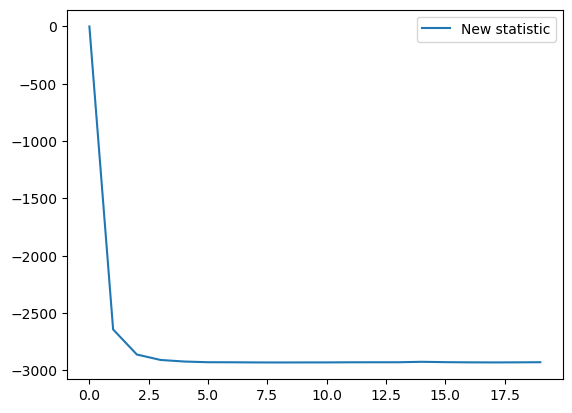

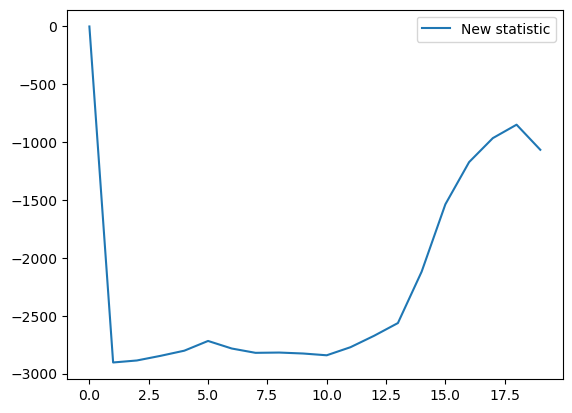

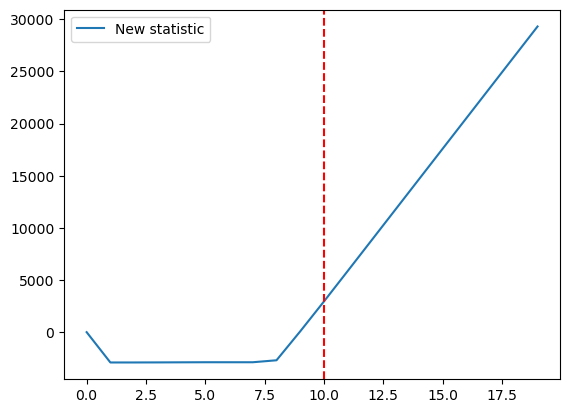

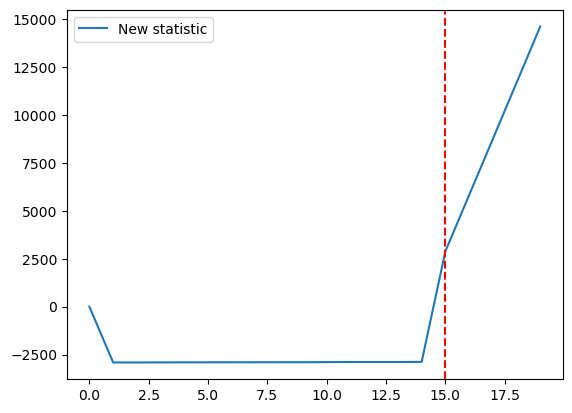

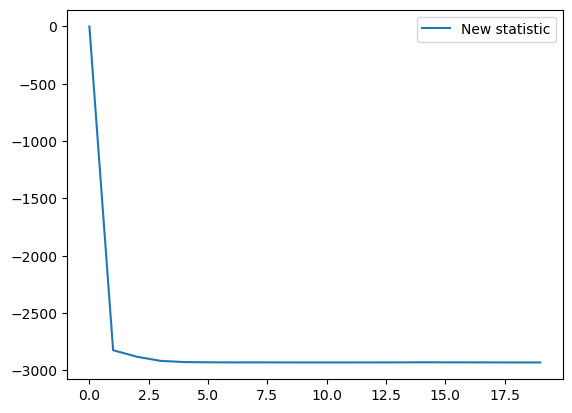

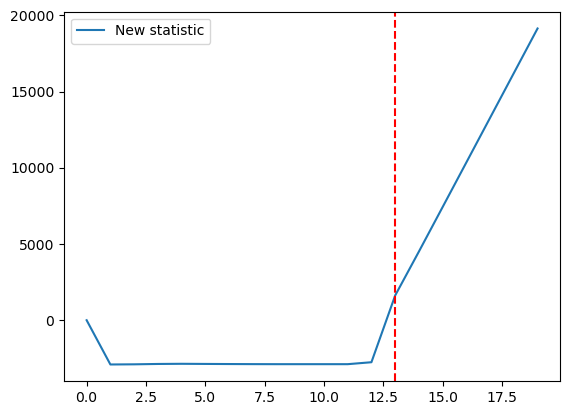

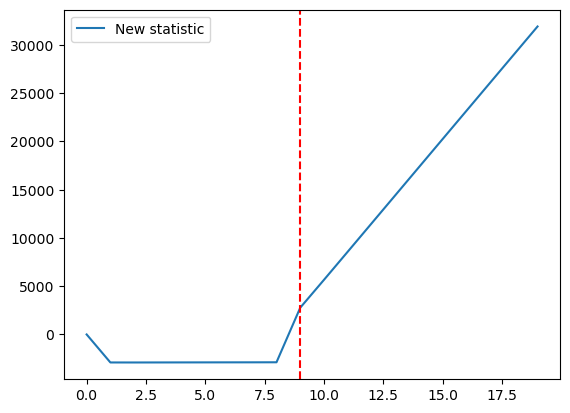

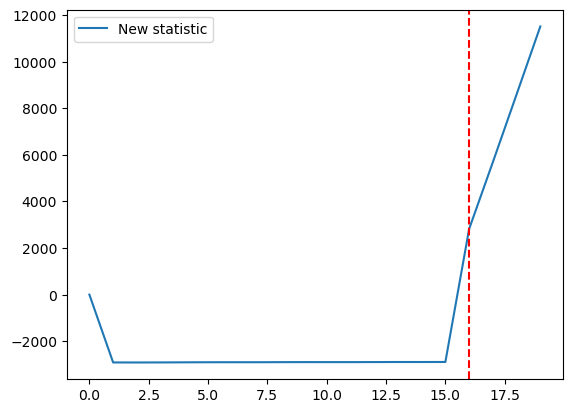

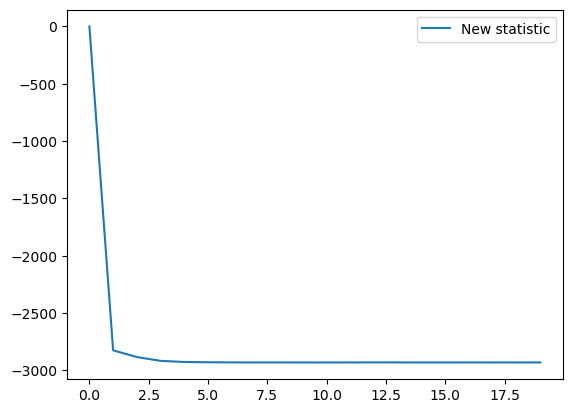

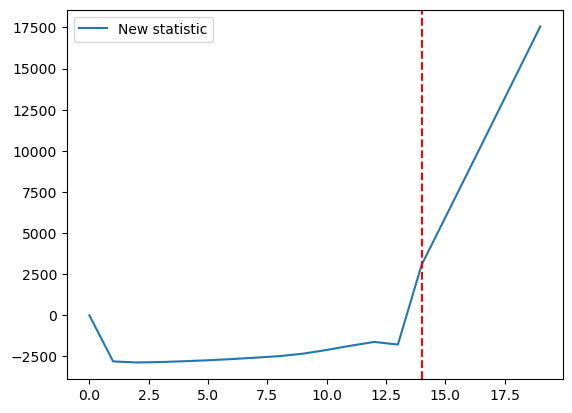

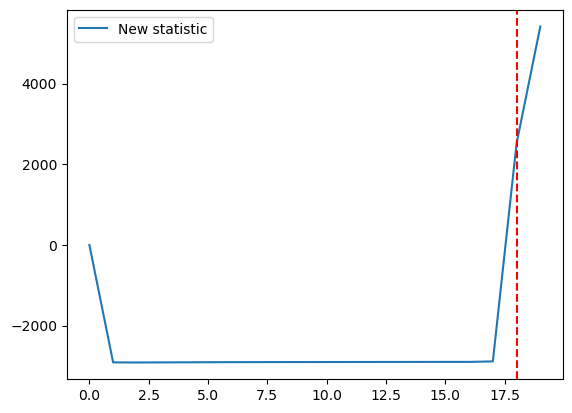

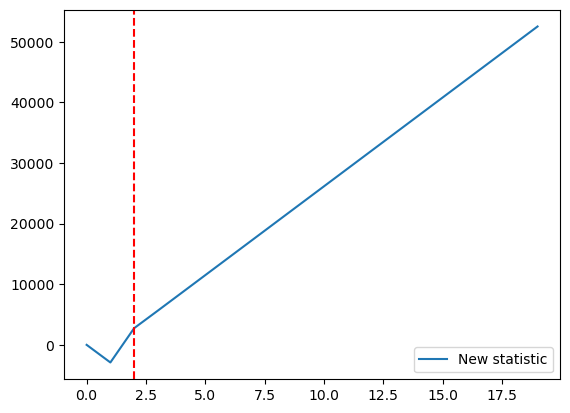

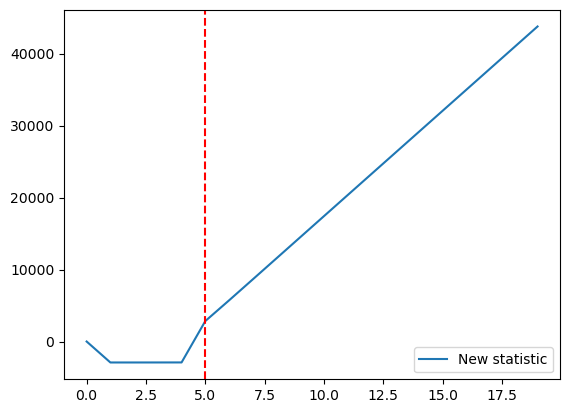

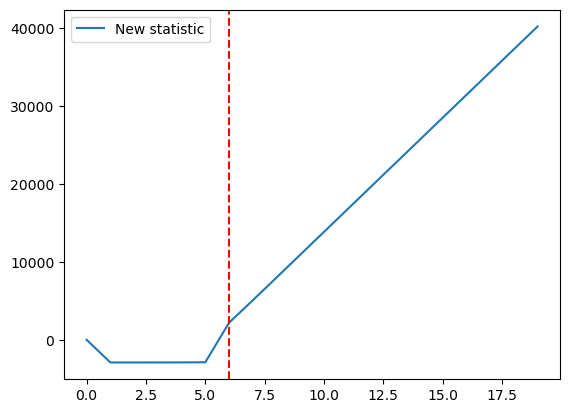

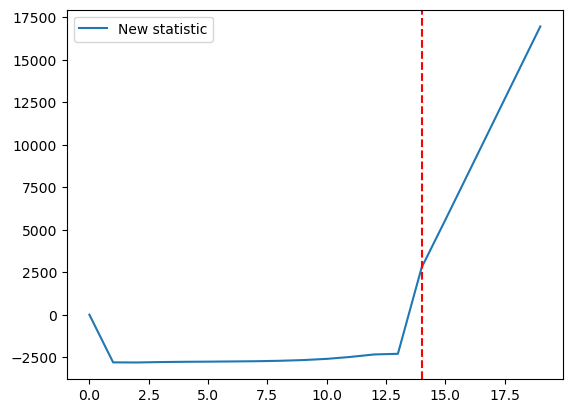

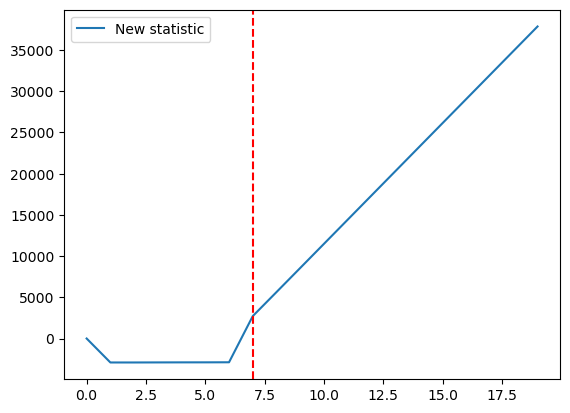

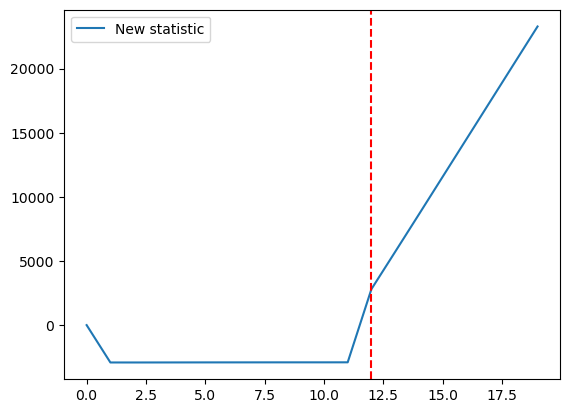

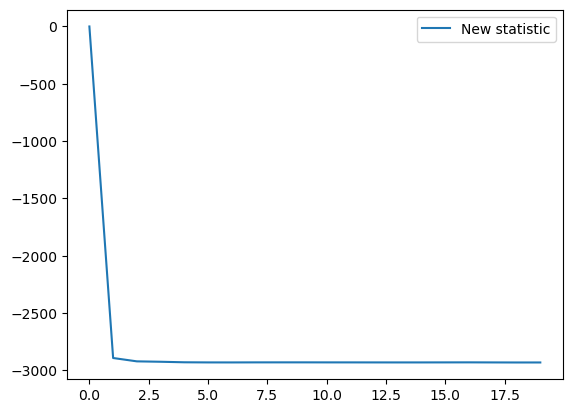

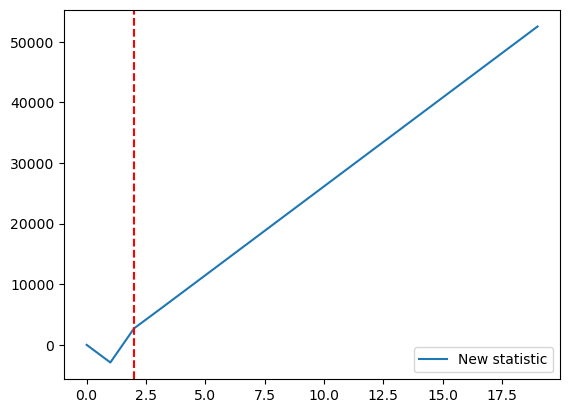

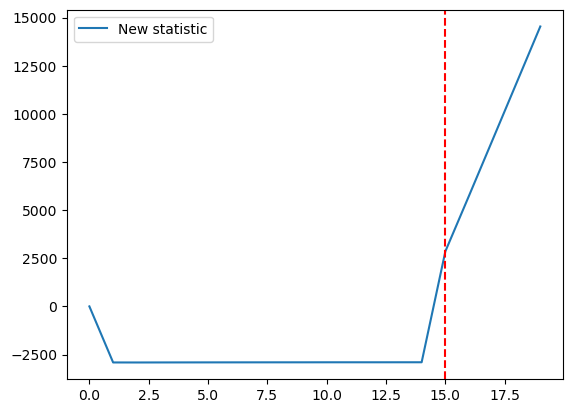

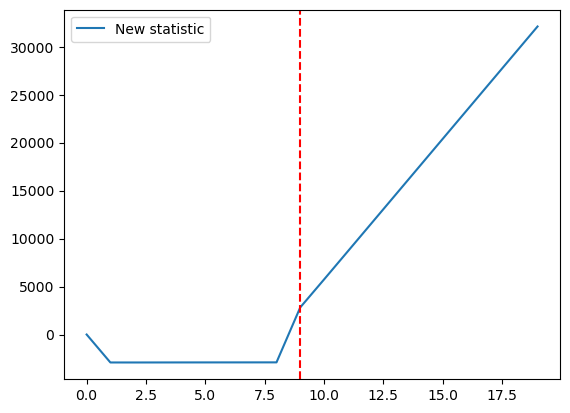

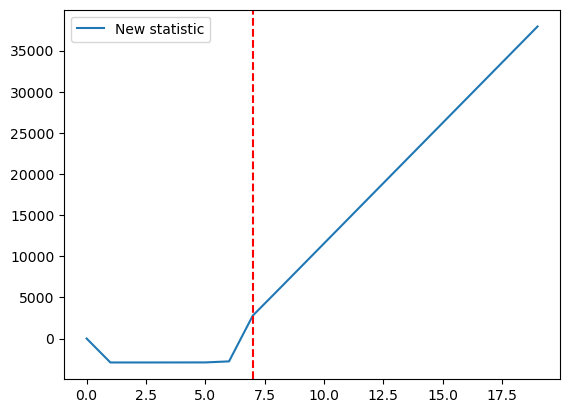

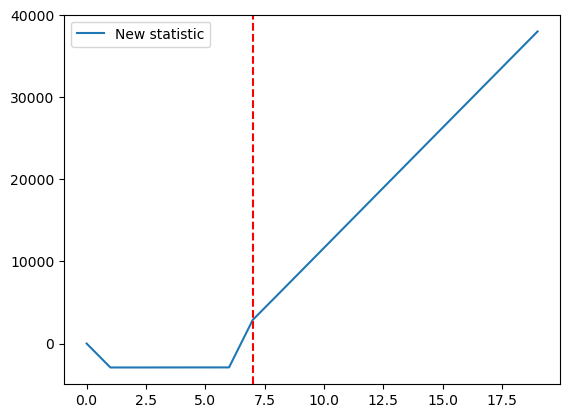

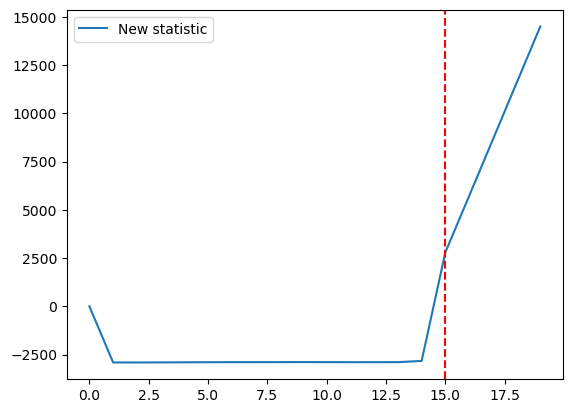

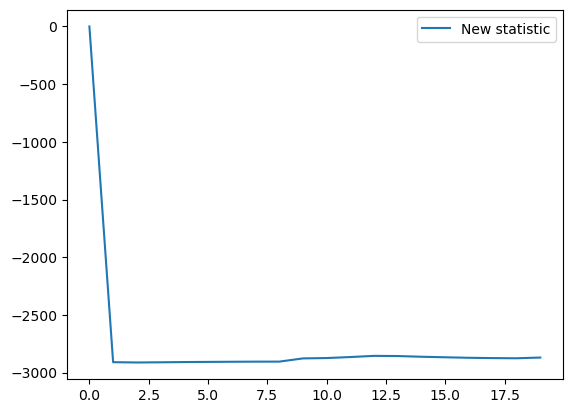

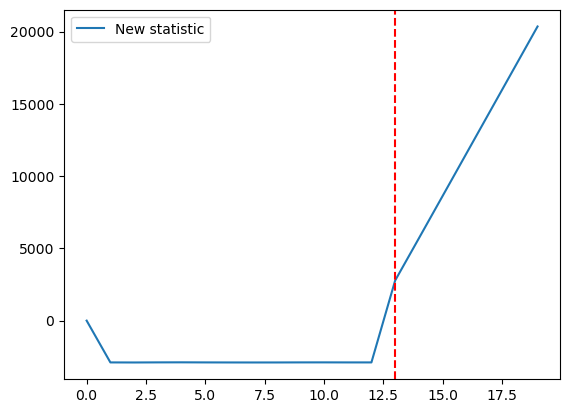

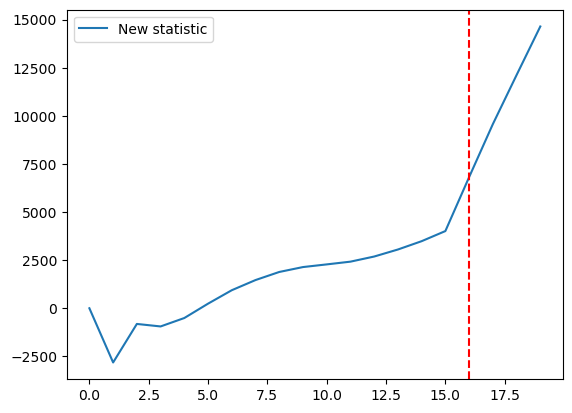

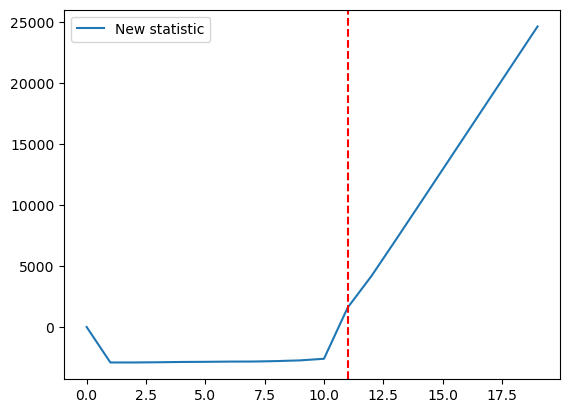

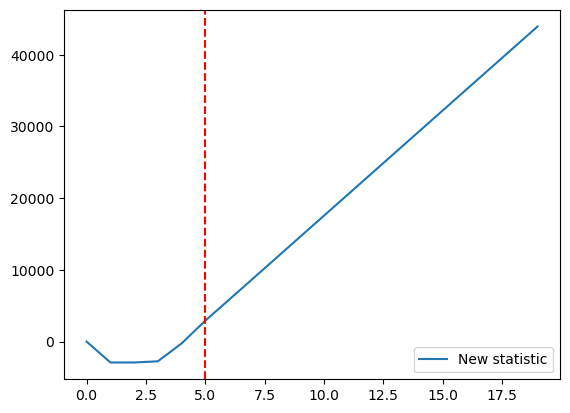

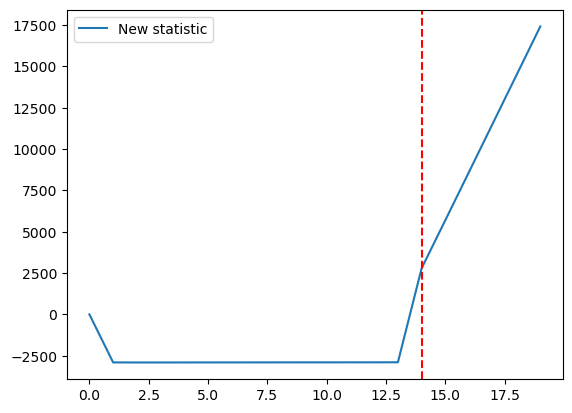

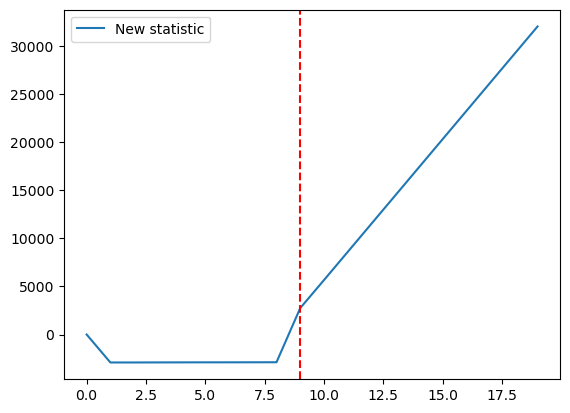

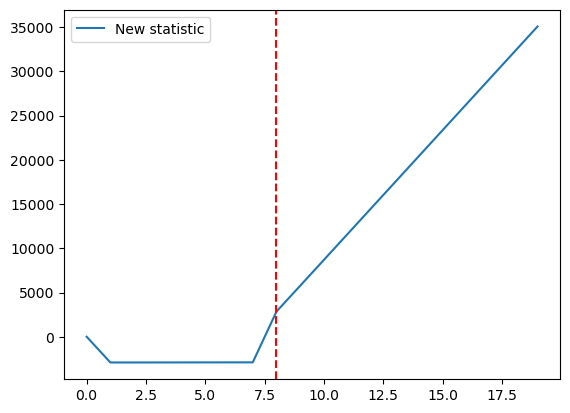

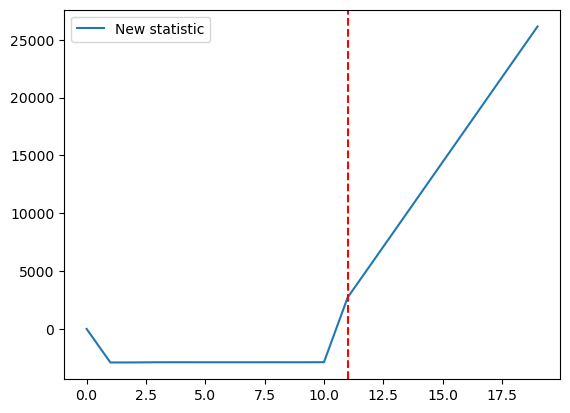

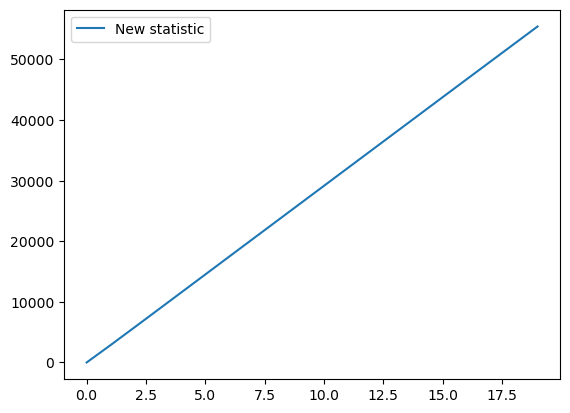

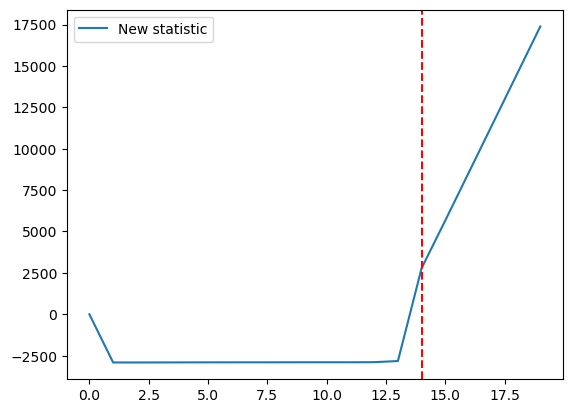

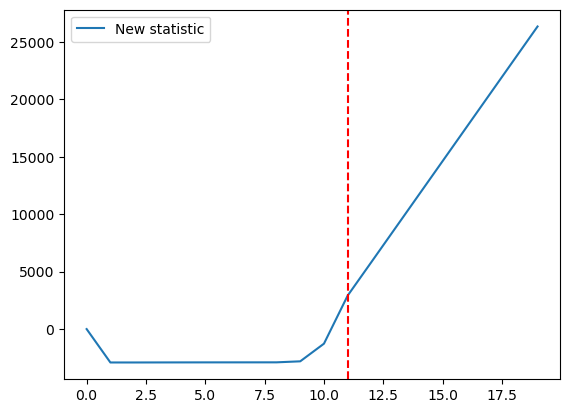

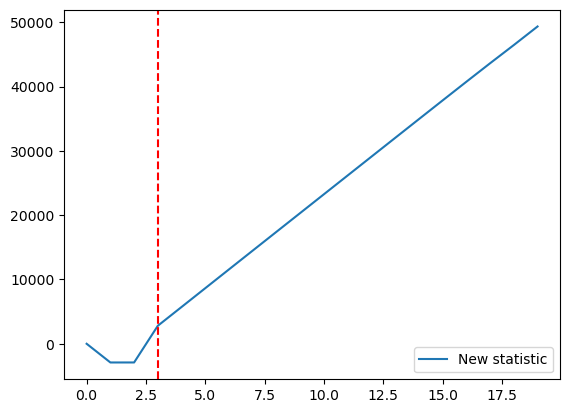

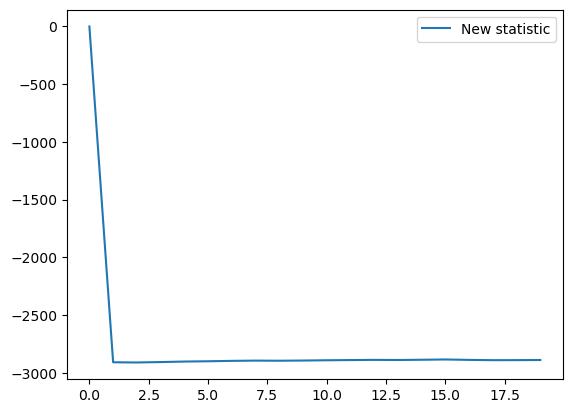

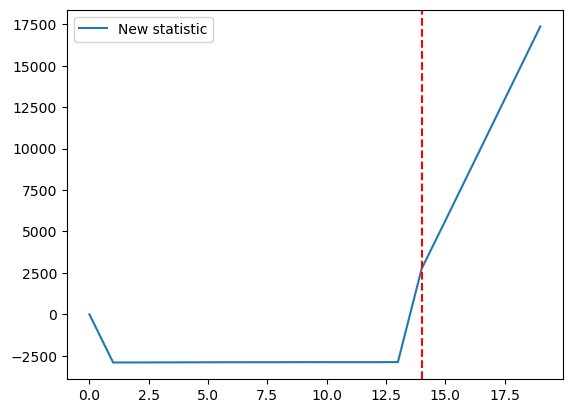

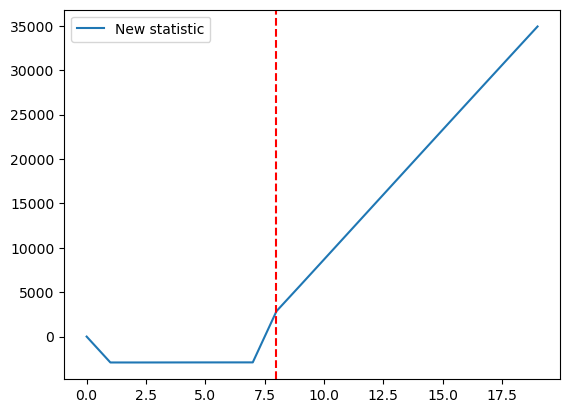

In [80]:
for IDX in range(40):

    change_idx = labels_batch[IDX].detach().cpu().numpy().argmax()

    plt.figure()
    plt.plot(cusum_stat[IDX], label="New statistic")
    if change_idx > 0:
        plt.axvline(x = change_idx, c="red", linestyle="--")
    plt.legend()
    plt.show()

In [83]:
cusum_threshold_list = np.linspace(0, 10, 21) * 1000
cusum_threshold_list

array([    0.,   500.,  1000.,  1500.,  2000.,  2500.,  3000.,  3500.,
        4000.,  4500.,  5000.,  5500.,  6000.,  6500.,  7000.,  7500.,
        8000.,  8500.,  9000.,  9500., 10000.])

In [84]:
threshold_list = [0.5]

for cusum_threshold in cusum_threshold_list:
    print("cusum_threshold:", cusum_threshold)
    ens_har_bce_new_aggr = AggregationEnsembleCPDModel(
        args_config,
        n_models=10,
        global_sigma=global_sigma,
        lambda_null=lambda_null,
        lambda_inf=lambda_inf,
        half_wnd=half_wnd,
        cusum_threshold=cusum_threshold,
    )
    ens_har_bce_new_aggr.load_models_list("saved_models/human_activity/full_sample")

    metrics_local, delay_list, fp_delay_list = \
        metrics.evaluation_pipeline(ens_har_bce_new_aggr,
                                    test_dataloader,
                                    threshold_list,
                                    device="cuda", # choose 'cpu' or 'cuda' if available
                                    model_type="cusum_aggr",
                                    verbose=True,
                                    )

cusum_threshold: 0.0


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.61s/it]

TN: 157, FP: 33, FN: 2, TP: 1145, DELAY:0.06507105380296707, FP_DELAY:10.314884185791016, COVER: 0.988980861021332
AUC: None
Time to FA 10.3149, delay detection 0.0651 for best-F1 threshold: 0.5
TN 157, FP 33, FN 2, TP 1145 for best-F1 threshold: 0.5
Max F1 0.9849: for best-F1 threshold 0.5
COVER 0.989: for best-F1 threshold 0.5
Max COVER 0.989: for threshold 0.5
cusum_threshold: 500.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/it]

TN: 158, FP: 23, FN: 3, TP: 1153, DELAY:0.08302169293165207, FP_DELAY:10.381450653076172, COVER: 0.9890872296770802
AUC: None
Time to FA 10.3815, delay detection 0.083 for best-F1 threshold: 0.5
TN 158, FP 23, FN 3, TP 1153 for best-F1 threshold: 0.5
Max F1 0.9889: for best-F1 threshold 0.5
COVER 0.9891: for best-F1 threshold 0.5
Max COVER 0.9891: for threshold 0.5
cusum_threshold: 1000.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/it]

TN: 160, FP: 15, FN: 6, TP: 1156, DELAY:0.13014210760593414, FP_DELAY:10.469708442687988, COVER: 0.9883342068025514
AUC: None
Time to FA 10.4697, delay detection 0.1301 for best-F1 threshold: 0.5
TN 160, FP 15, FN 6, TP 1156 for best-F1 threshold: 0.5
Max F1 0.991: for best-F1 threshold 0.5
COVER 0.9883: for best-F1 threshold 0.5
Max COVER 0.9883: for threshold 0.5
cusum_threshold: 1500.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.68s/it]

TN: 162, FP: 8, FN: 10, TP: 1157, DELAY:0.22737471759319305, FP_DELAY:10.54001522064209, COVER: 0.9836245611685288
AUC: None
Time to FA 10.54, delay detection 0.2274 for best-F1 threshold: 0.5
TN 162, FP 8, FN 10, TP 1157 for best-F1 threshold: 0.5
Max F1 0.9923: for best-F1 threshold 0.5
COVER 0.9836: for best-F1 threshold 0.5
Max COVER 0.9836: for threshold 0.5
cusum_threshold: 2000.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/it]

TN: 162, FP: 5, FN: 34, TP: 1136, DELAY:0.931189239025116, FP_DELAY:10.590126991271973, COVER: 0.9201495822741865
AUC: None
Time to FA 10.5901, delay detection 0.9312 for best-F1 threshold: 0.5
TN 162, FP 5, FN 34, TP 1136 for best-F1 threshold: 0.5
Max F1 0.9831: for best-F1 threshold 0.5
COVER 0.9201: for best-F1 threshold 0.5
Max COVER 0.9201: for threshold 0.5
cusum_threshold: 2500.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/it]

TN: 162, FP: 4, FN: 40, TP: 1131, DELAY:0.9730740189552307, FP_DELAY:10.602842330932617, COVER: 0.9168504621325342
AUC: None
Time to FA 10.6028, delay detection 0.9731 for best-F1 threshold: 0.5
TN 162, FP 4, FN 40, TP 1131 for best-F1 threshold: 0.5
Max F1 0.9809: for best-F1 threshold 0.5
COVER 0.9169: for best-F1 threshold 0.5
Max COVER 0.9169: for threshold 0.5
cusum_threshold: 3000.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/it]

TN: 162, FP: 3, FN: 42, TP: 1130, DELAY:1.0142109394073486, FP_DELAY:10.610321998596191, COVER: 0.9137663837241513
AUC: None
Time to FA 10.6103, delay detection 1.0142 for best-F1 threshold: 0.5
TN 162, FP 3, FN 42, TP 1130 for best-F1 threshold: 0.5
Max F1 0.9805: for best-F1 threshold 0.5
COVER 0.9138: for best-F1 threshold 0.5
Max COVER 0.9138: for threshold 0.5
cusum_threshold: 3500.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/it]

TN: 162, FP: 3, FN: 49, TP: 1123, DELAY:1.210919976234436, FP_DELAY:10.620792388916016, COVER: 0.8979084124511104
AUC: None
Time to FA 10.6208, delay detection 1.2109 for best-F1 threshold: 0.5
TN 162, FP 3, FN 49, TP 1123 for best-F1 threshold: 0.5
Max F1 0.9774: for best-F1 threshold 0.5
COVER 0.8979: for best-F1 threshold 0.5
Max COVER 0.8979: for threshold 0.5
cusum_threshold: 4000.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/it]

TN: 162, FP: 3, FN: 73, TP: 1099, DELAY:1.7673896551132202, FP_DELAY:10.659686088562012, COVER: 0.8505128375006369
AUC: None
Time to FA 10.6597, delay detection 1.7674 for best-F1 threshold: 0.5
TN 162, FP 3, FN 73, TP 1099 for best-F1 threshold: 0.5
Max F1 0.9666: for best-F1 threshold 0.5
COVER 0.8505: for best-F1 threshold 0.5
Max COVER 0.8505: for threshold 0.5
cusum_threshold: 4500.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/it]

TN: 162, FP: 3, FN: 74, TP: 1098, DELAY:1.8017950057983398, FP_DELAY:10.661930084228516, COVER: 0.8480989087421412
AUC: None
Time to FA 10.6619, delay detection 1.8018 for best-F1 threshold: 0.5
TN 162, FP 3, FN 74, TP 1098 for best-F1 threshold: 0.5
Max F1 0.9661: for best-F1 threshold 0.5
COVER 0.8481: for best-F1 threshold 0.5
Max COVER 0.8481: for threshold 0.5
cusum_threshold: 5000.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/it]

TN: 162, FP: 3, FN: 76, TP: 1096, DELAY:1.8481675386428833, FP_DELAY:10.665669441223145, COVER: 0.844862837347599
AUC: None
Time to FA 10.6657, delay detection 1.8482 for best-F1 threshold: 0.5
TN 162, FP 3, FN 76, TP 1096 for best-F1 threshold: 0.5
Max F1 0.9652: for best-F1 threshold 0.5
COVER 0.8449: for best-F1 threshold 0.5
Max COVER 0.8449: for threshold 0.5
cusum_threshold: 5500.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/it]

TN: 162, FP: 3, FN: 104, TP: 1068, DELAY:2.5033657550811768, FP_DELAY:10.730740547180176, COVER: 0.7940268945411315
AUC: None
Time to FA 10.7307, delay detection 2.5034 for best-F1 threshold: 0.5
TN 162, FP 3, FN 104, TP 1068 for best-F1 threshold: 0.5
Max F1 0.9523: for best-F1 threshold 0.5
COVER 0.794: for best-F1 threshold 0.5
Max COVER 0.794: for threshold 0.5
cusum_threshold: 6000.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/it]

TN: 162, FP: 3, FN: 109, TP: 1063, DELAY:2.5602095127105713, FP_DELAY:10.744203567504883, COVER: 0.7899474697433759
AUC: None
Time to FA 10.7442, delay detection 2.5602 for best-F1 threshold: 0.5
TN 162, FP 3, FN 109, TP 1063 for best-F1 threshold: 0.5
Max F1 0.95: for best-F1 threshold 0.5
COVER 0.7899: for best-F1 threshold 0.5
Max COVER 0.7899: for threshold 0.5
cusum_threshold: 6500.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/it]

TN: 162, FP: 3, FN: 113, TP: 1059, DELAY:2.595362663269043, FP_DELAY:10.756170272827148, COVER: 0.7876921912611783
AUC: None
Time to FA 10.7562, delay detection 2.5954 for best-F1 threshold: 0.5
TN 162, FP 3, FN 113, TP 1059 for best-F1 threshold: 0.5
Max F1 0.9481: for best-F1 threshold 0.5
COVER 0.7877: for best-F1 threshold 0.5
Max COVER 0.7877: for threshold 0.5
cusum_threshold: 7000.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/it]

TN: 162, FP: 3, FN: 120, TP: 1052, DELAY:2.7000749111175537, FP_DELAY:10.788331985473633, COVER: 0.7809678215612352
AUC: None
Time to FA 10.7883, delay detection 2.7001 for best-F1 threshold: 0.5
TN 162, FP 3, FN 120, TP 1052 for best-F1 threshold: 0.5
Max F1 0.9448: for best-F1 threshold 0.5
COVER 0.781: for best-F1 threshold 0.5
Max COVER 0.781: for threshold 0.5
cusum_threshold: 7500.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/it]

TN: 162, FP: 3, FN: 158, TP: 1014, DELAY:3.3014211654663086, FP_DELAY:10.905011177062988, COVER: 0.737696259728885
AUC: None
Time to FA 10.905, delay detection 3.3014 for best-F1 threshold: 0.5
TN 162, FP 3, FN 158, TP 1014 for best-F1 threshold: 0.5
Max F1 0.9265: for best-F1 threshold 0.5
COVER 0.7377: for best-F1 threshold 0.5
Max COVER 0.7377: for threshold 0.5
cusum_threshold: 8000.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/it]

TN: 162, FP: 3, FN: 161, TP: 1011, DELAY:3.3261032104492188, FP_DELAY:10.92595386505127, COVER: 0.7363890487233131
AUC: None
Time to FA 10.926, delay detection 3.3261 for best-F1 threshold: 0.5
TN 162, FP 3, FN 161, TP 1011 for best-F1 threshold: 0.5
Max F1 0.925: for best-F1 threshold 0.5
COVER 0.7364: for best-F1 threshold 0.5
Max COVER 0.7364: for threshold 0.5
cusum_threshold: 8500.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/it]

TN: 162, FP: 3, FN: 163, TP: 1009, DELAY:3.3575167655944824, FP_DELAY:10.933433532714844, COVER: 0.7346138368683196
AUC: None
Time to FA 10.9334, delay detection 3.3575 for best-F1 threshold: 0.5
TN 162, FP 3, FN 163, TP 1009 for best-F1 threshold: 0.5
Max F1 0.924: for best-F1 threshold 0.5
COVER 0.7346: for best-F1 threshold 0.5
Max COVER 0.7346: for threshold 0.5
cusum_threshold: 9000.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.66s/it]

TN: 162, FP: 3, FN: 175, TP: 997, DELAY:3.5504860877990723, FP_DELAY:10.979805946350098, COVER: 0.7222632123747555
AUC: None
Time to FA 10.9798, delay detection 3.5505 for best-F1 threshold: 0.5
TN 162, FP 3, FN 175, TP 997 for best-F1 threshold: 0.5
Max F1 0.918: for best-F1 threshold 0.5
COVER 0.7223: for best-F1 threshold 0.5
Max COVER 0.7223: for threshold 0.5
cusum_threshold: 9500.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.67s/it]

TN: 162, FP: 3, FN: 215, TP: 957, DELAY:4.023934364318848, FP_DELAY:11.130142211914062, COVER: 0.6916628098016687
AUC: None
Time to FA 11.1301, delay detection 4.0239 for best-F1 threshold: 0.5
TN 162, FP 3, FN 215, TP 957 for best-F1 threshold: 0.5
Max F1 0.8977: for best-F1 threshold 0.5
COVER 0.6917: for best-F1 threshold 0.5
Max COVER 0.6917: for threshold 0.5
cusum_threshold: 10000.0



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/it]

TN: 162, FP: 3, FN: 217, TP: 955, DELAY:4.04936408996582, FP_DELAY:11.139864921569824, COVER: 0.69036146076335
AUC: None
Time to FA 11.1399, delay detection 4.0494 for best-F1 threshold: 0.5
TN 162, FP 3, FN 217, TP 955 for best-F1 threshold: 0.5
Max F1 0.8967: for best-F1 threshold 0.5
COVER 0.6904: for best-F1 threshold 0.5
Max COVER 0.6904: for threshold 0.5
